# COVID-19 Data Analyses using New York Times Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is 
[COVID-19 data from The New York Times](https://github.com/nytimes/covid-19-data).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the New York Times COVID-19 CSV files into [Pandas](https://pandas.pydata.org/) DataFrames. It
then manipulates, queries, and plots data via the DataFrames.

[**I don't want to look at code. Take me to the first graph!**](#United-States-as-a-whole)


[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date, timezone
import os
import sys
import re
import math
from pprint import pprint
from collections import namedtuple
from lib.common import *
from lib.plot import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")
now = datetime.now(timezone.utc)
print(f"Last run on {now.strftime('%Y-%m-%d')} at {now.strftime('%H:%M:%S %Z')}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5
Last run on 2020-09-10 at 17:13:48 UTC


In [2]:
NYTIMES_DIR_PATH = 'data/nytimes/covid-19-data'
SOURCE = "New York Times"
US_DATA = os.path.join(NYTIMES_DIR_PATH, 'us.csv')
US_STATE_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-states.csv')
US_COUNTY_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-counties.csv')

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## State population data

In [4]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,340


## Read the New York Times data

In [5]:
def read_us_data(path: str) -> pd.DataFrame:
    """
    Reads the New York Times COVID-19 US-wide CSV file
    into a Pandas DataFrame, converting the date field
    to the appropriate type. Removes any records prior
    to April 12. Also adds a month_day string column.
    """
    df = pd.read_csv(path).rename(columns={
            'date':   COL_DATE,
            'state':  COL_REGION,
            'cases':  COL_CASES,
            'deaths': COL_DEATHS
        })
    df = df[[COL_DATE, COL_REGION, COL_CASES, COL_DEATHS]]

    df[COL_DATE] = pd.to_datetime(df[COL_DATE], format='%Y-%m-%d')
    df[COL_DEATHS].fillna(0)
    df[COL_CASES].fillna(0)

    df[COL_HOSPITALIZATIONS] = 0
    df[COL_RECOVERIES] = 0
    df[COL_TESTS] = 0

    for col in (COL_DEATHS, COL_CASES):
        df[col] = df[col].fillna(0)

    make_month_day_column(df)
    return df.loc[df[COL_DATE] >= STARTING_DATE]

In [6]:
def read_us_county_data(path: str) -> pd.DataFrame:
    """
    Reads the New York Times COVID-19 US county CSV file
    into a Pandas DataFrame, converting the date field
    to the appropriate type. Removes any records prior
    to April 12. Also adds a month_day string column.
    """
    df = pd.read_csv(path).rename(columns={
        'date':   COL_DATE,
        'county': COL_COUNTY,
        'state':  COL_REGION,
        'cases':  COL_CASES,
        'deaths': COL_DEATHS
    })
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df.cases.fillna(0)
    df.deaths.fillna(0)
    make_month_day_column(df)
    return df.loc[df[COL_DATE] >= STARTING_DATE]

In [7]:
%ls $NYTIMES_DIR_PATH

excess-deaths/  mask-use/                       README.md        us-states.csv
LICENSE         NEW-YORK-DEATHS-METHODOLOGY.md  us-counties.csv
live/           PROBABLE-CASES-NOTE.md          us.csv


In [8]:
%head $NYTIMES_DIR_PATH/us.csv

date,cases,deaths
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0
2020-01-26,5,0
2020-01-27,5,0
2020-01-28,5,0
2020-01-29,5,0


In [9]:
df_states = read_us_data(US_STATE_DATA)
print(f"Read data for {len(df_states.date.unique())} days.")
start_date = df_states.date.min()
end_date = df_states.date.max()
print(f"Starting date: {datestr(start_date.date(), include_year=True)}")
print(f"Ending date: {datestr(end_date.date(), include_year=True)}")

Read data for 151 days.
Starting date: 04/12/2020
Ending date: 09/09/2020


In [10]:
df_states

date         region   cases  deaths  hospitalizations  recoveries  \
2214  2020-04-12        Alabama    3583      93                 0           0   
2215  2020-04-12         Alaska     270       6                 0           0   
2216  2020-04-12        Arizona    3539     117                 0           0   
2217  2020-04-12       Arkansas    1280      27                 0           0   
2218  2020-04-12     California   23323     676                 0           0   
...          ...            ...     ...     ...               ...         ...   
10514 2020-09-09       Virginia  129289    2697                 0           0   
10515 2020-09-09     Washington   81529    2067                 0           0   
10516 2020-09-09  West Virginia   11808     254                 0           0   
10517 2020-09-09      Wisconsin   88643    1193                 0           0   
10518 2020-09-09        Wyoming    4151      42                 0           0   

       tests month_day  
2214       0     04/12  
2215       0     04/12  
2216       0     04/12  
2217       0     04/12  
2218       0     04/12  
...      ...       ...  
10514      0     09/09  
10515      0     09/09  
10516      0     09/09  
10517      0     09/09  
10518      0     09/09  

[8305 rows x 8 columns]

In [11]:
df_counties = read_us_county_data(US_COUNTY_DATA)
print(f"Read data for {len(df_counties[COL_DATE].unique())} days.")
print(f"Starting date: {datestr(df_counties[COL_DATE].min(), include_year=True)}")
print(f"Ending date: {datestr(df_counties[COL_DATE].max(), include_year=True)}")

Read data for 151 days.
Starting date: 04/12/2020
Ending date: 09/09/2020


In [12]:
df_counties

date      county   region     fips  cases  deaths month_day
51087  2020-04-12     Autauga  Alabama   1001.0     19       1     04/12
51088  2020-04-12     Baldwin  Alabama   1003.0     71       1     04/12
51089  2020-04-12     Barbour  Alabama   1005.0     10       0     04/12
51090  2020-04-12        Bibb  Alabama   1007.0     16       0     04/12
51091  2020-04-12      Blount  Alabama   1009.0     13       0     04/12
...           ...         ...      ...      ...    ...     ...       ...
518292 2020-09-09  Sweetwater  Wyoming  56037.0    316       2     09/09
518293 2020-09-09       Teton  Wyoming  56039.0    451       1     09/09
518294 2020-09-09       Uinta  Wyoming  56041.0    308       2     09/09
518295 2020-09-09    Washakie  Wyoming  56043.0    110       6     09/09
518296 2020-09-09      Weston  Wyoming  56045.0     21       0     09/09

[467210 rows x 7 columns]

## Deaths and cases in a single region

### United States

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ac9f8b7c0>)

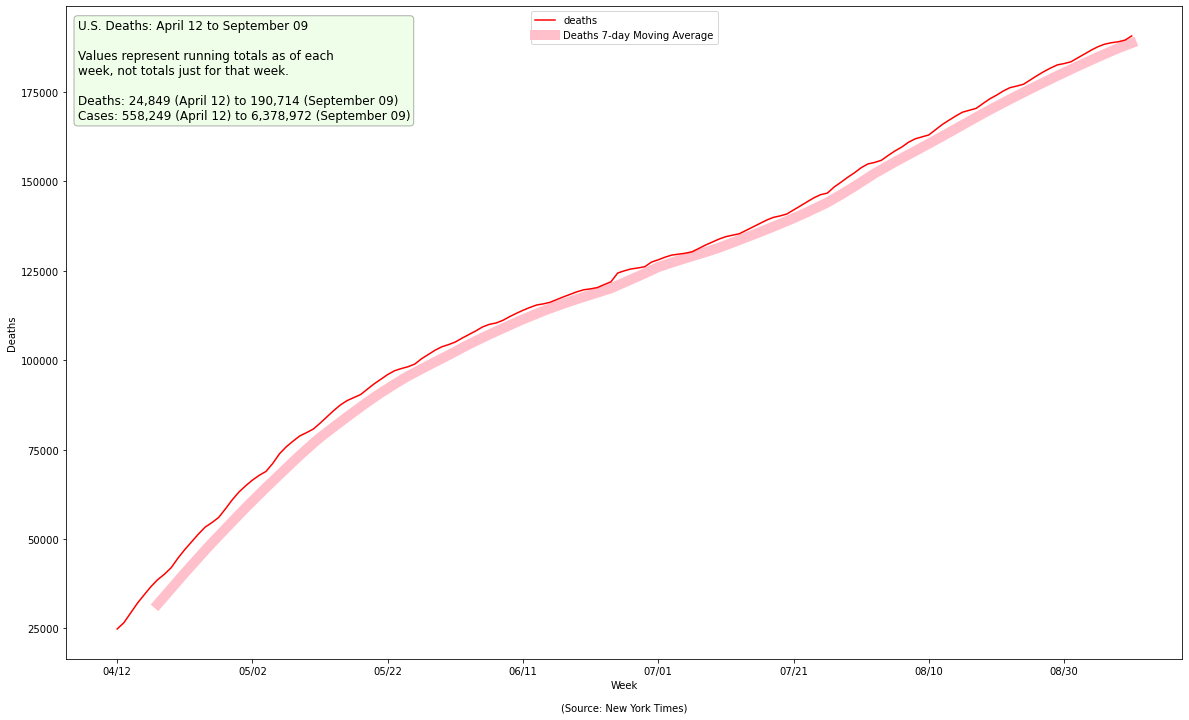

In [13]:
plot_stats_by_date(df_states, SOURCE, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='nyt-us-deaths.png', textbox_heading="U.S. Deaths")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2aca1ec070>)

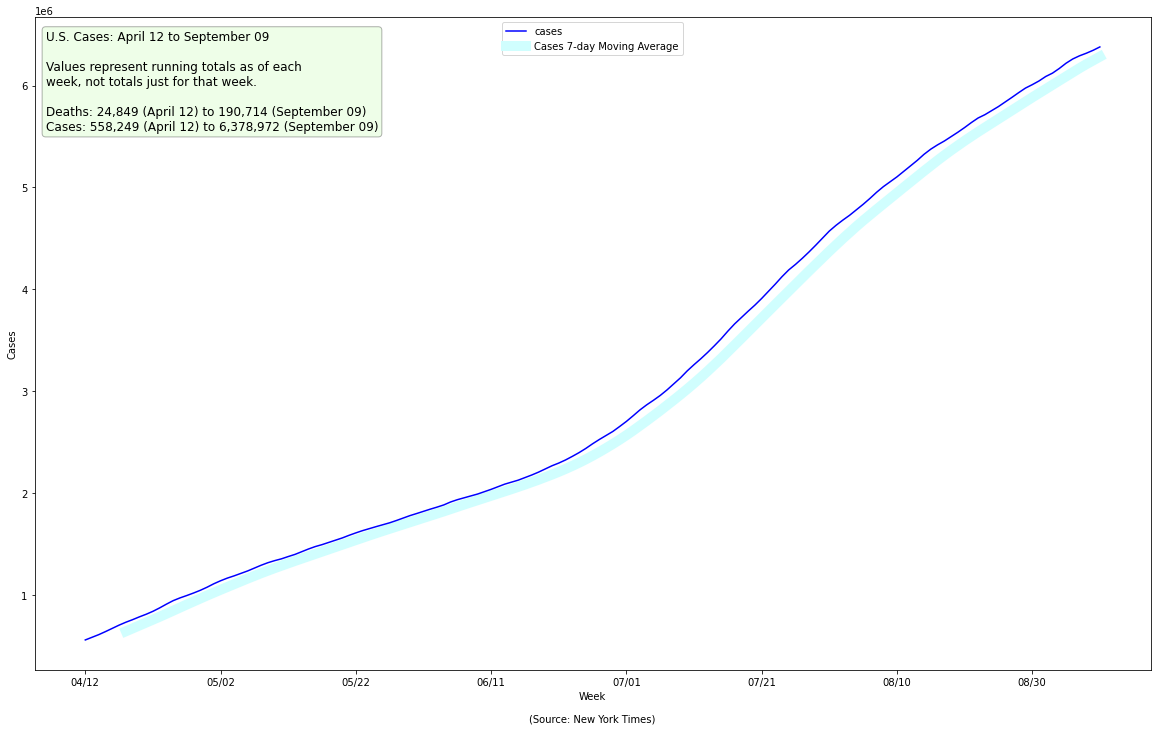

In [14]:
plot_stats_by_date(df_states, SOURCE, metrics={MetricType.CASES}, moving_average=True,
                   image_file='nyt-us-cases.png', textbox_heading="U.S. Cases")

#### Positivity Rate

The New York Times data set doesn't include data on tests, so
positivity rate can't be calculated.

#### Just the past week

In [15]:
week_delta = timedelta(days=6)
six_days_prior = end_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(end_date, hour=23, minute=59, second=59)

df_past_week = df_states.loc[(df_states.date >= last_week_start) & (df_states.date <= last_week_end)]

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2aca199700>)

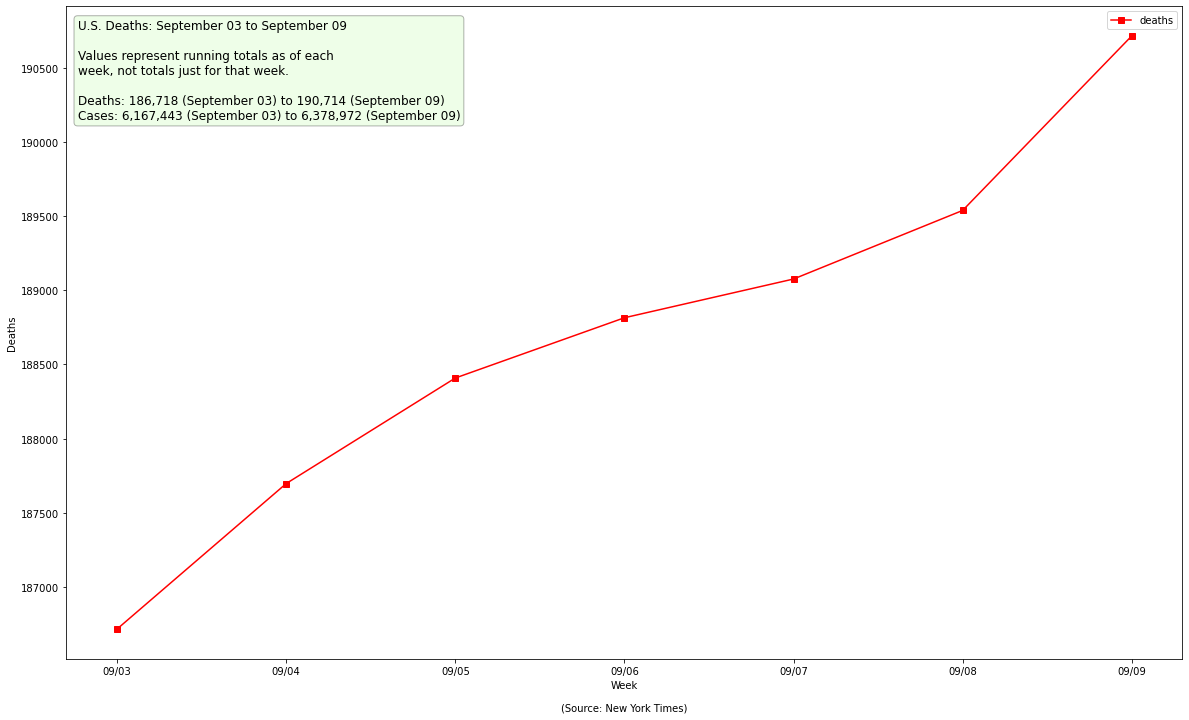

In [16]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='nyt-us-deaths-past-week.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2aca107b80>)

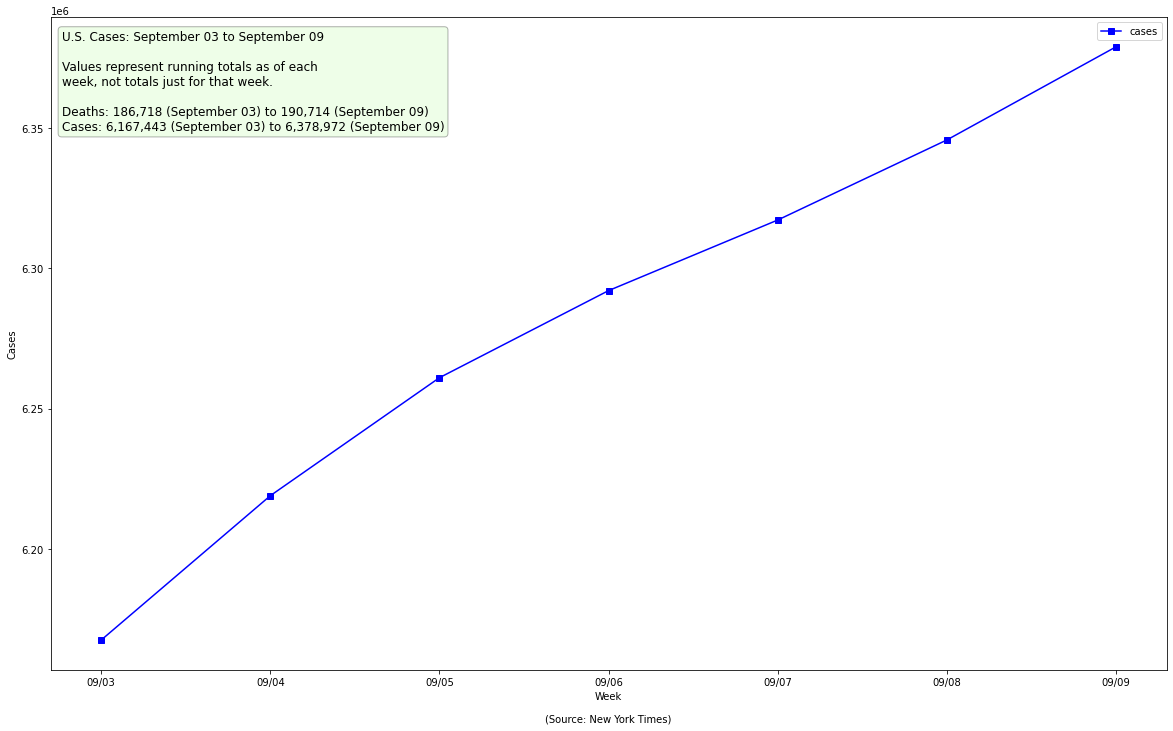

In [17]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.CASES}, marker='s', 
                   textbox_heading="U.S. Cases", image_file='nyt-us-cases-past-week.png')

#### Daily values, instead of cumulative values

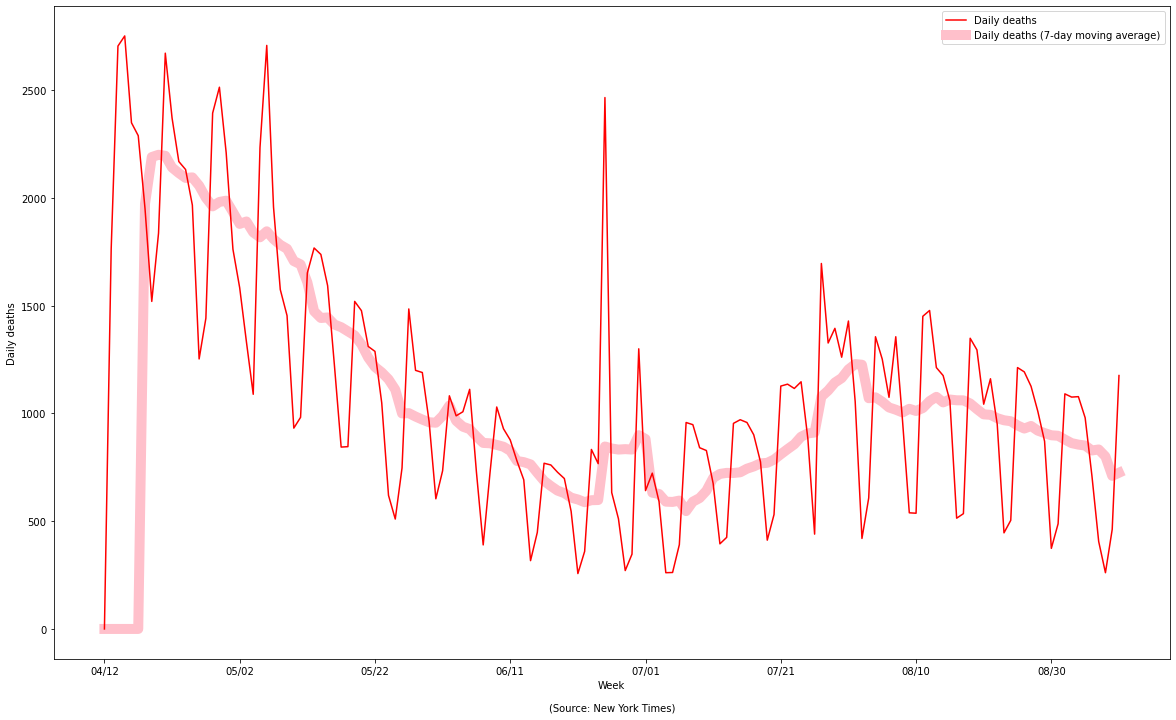

In [18]:
fig, ax, df_with_diffs = plot_daily_stats(df_states, 
                                          source=SOURCE,
                                          metric=MetricType.DEATHS,
                                          region='United States',
                                          moving_average=True,
                                          image_file="nyt-us-deaths-daily.png")

In [19]:
max_date = df_with_diffs.date.max()
df_with_diffs.loc[df_with_diffs.date == max_date]

date    cases  deaths  hospitalizations  recoveries  tests  \
150 2020-09-09  6378972  190714                 0           0      0   

            region month_day    diff     diff_ma  
150  United States     09/09  1176.0  724.857143

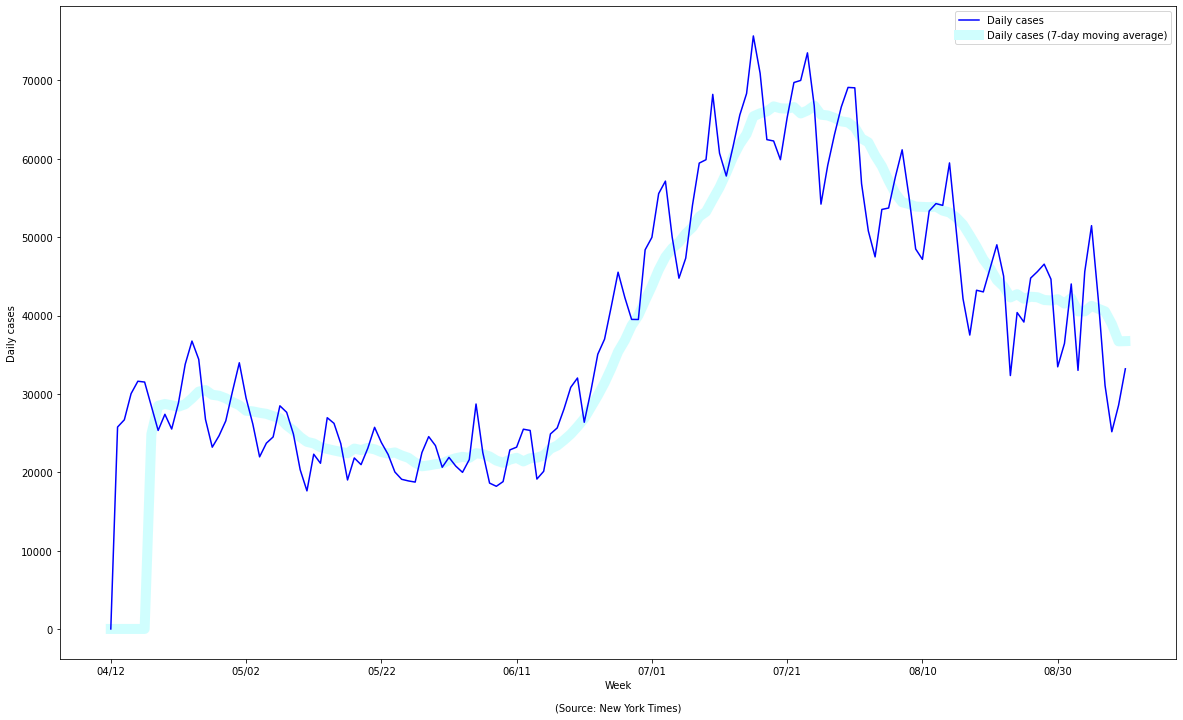

In [20]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='United States',
                 moving_average=True,
                 image_file="nyt-us-cases-daily.png");

#### Deaths vs. Cases

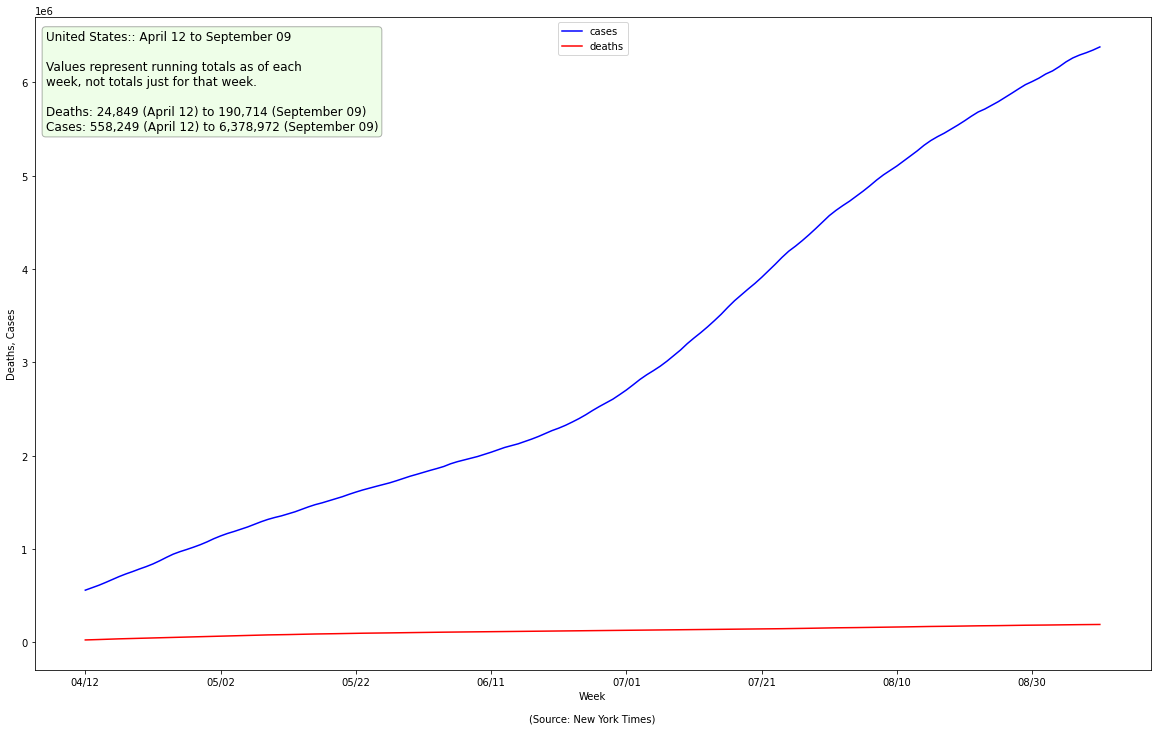

In [21]:
plot_stats_by_date(df_states, SOURCE, metrics={MetricType.DEATHS, MetricType.CASES}, 
                   textbox_heading="United States:", image_file="nyt-us-deaths-and-cases.png");

### Individual States

#### Pennsylvania

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5f889a0>)

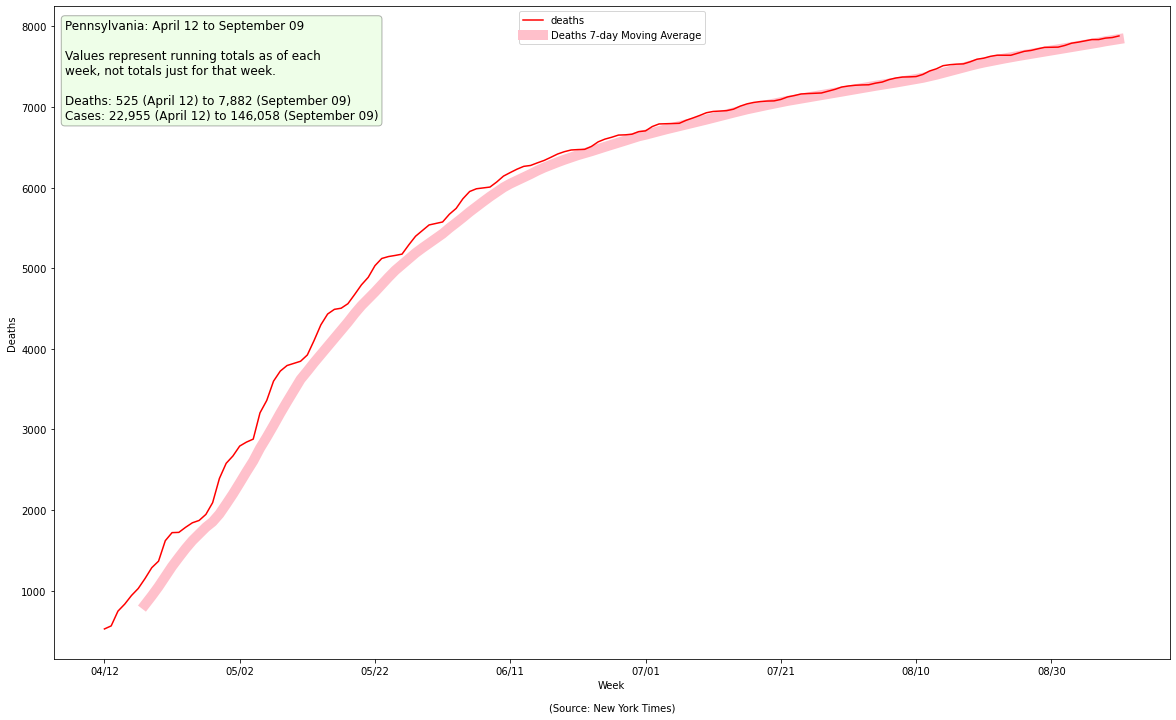

In [22]:
plot_state(df_states, SOURCE, 'Pennsylvania', moving_average=True,
           image_file='nyt-pa-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5f21670>)

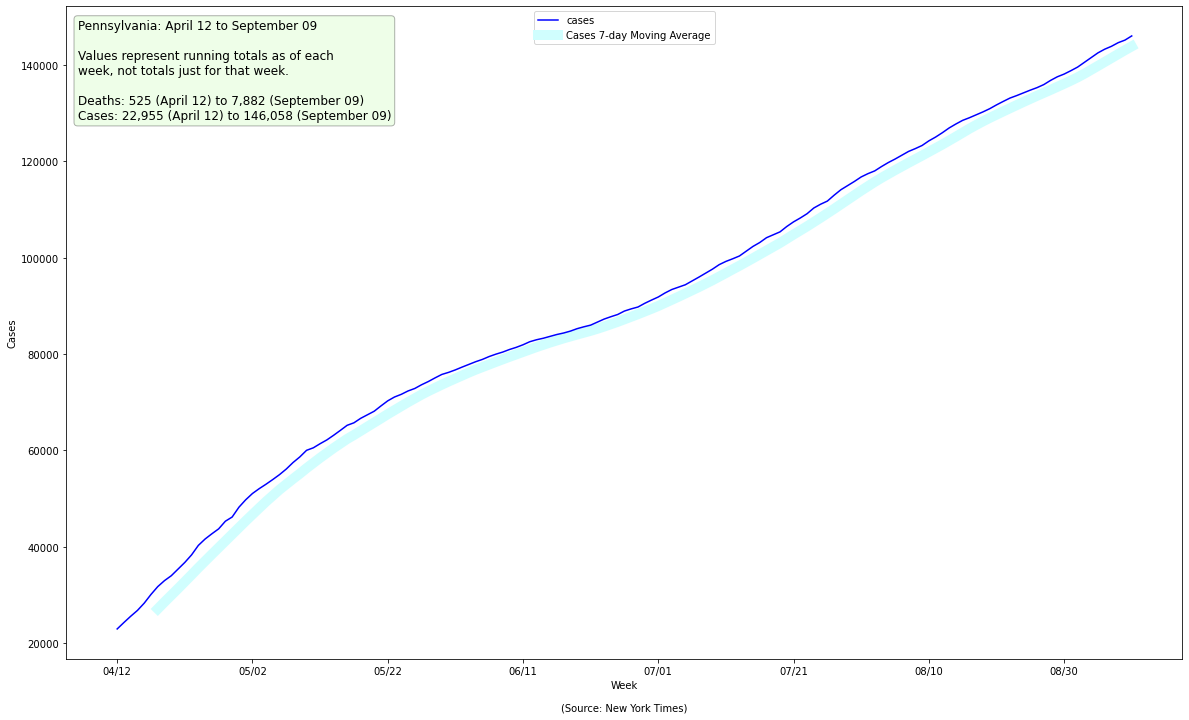

In [23]:
plot_state(df_states, SOURCE, 'Pennsylvania', moving_average=True,
           image_file='nyt-pa-cases.png', metrics={MetricType.CASES})

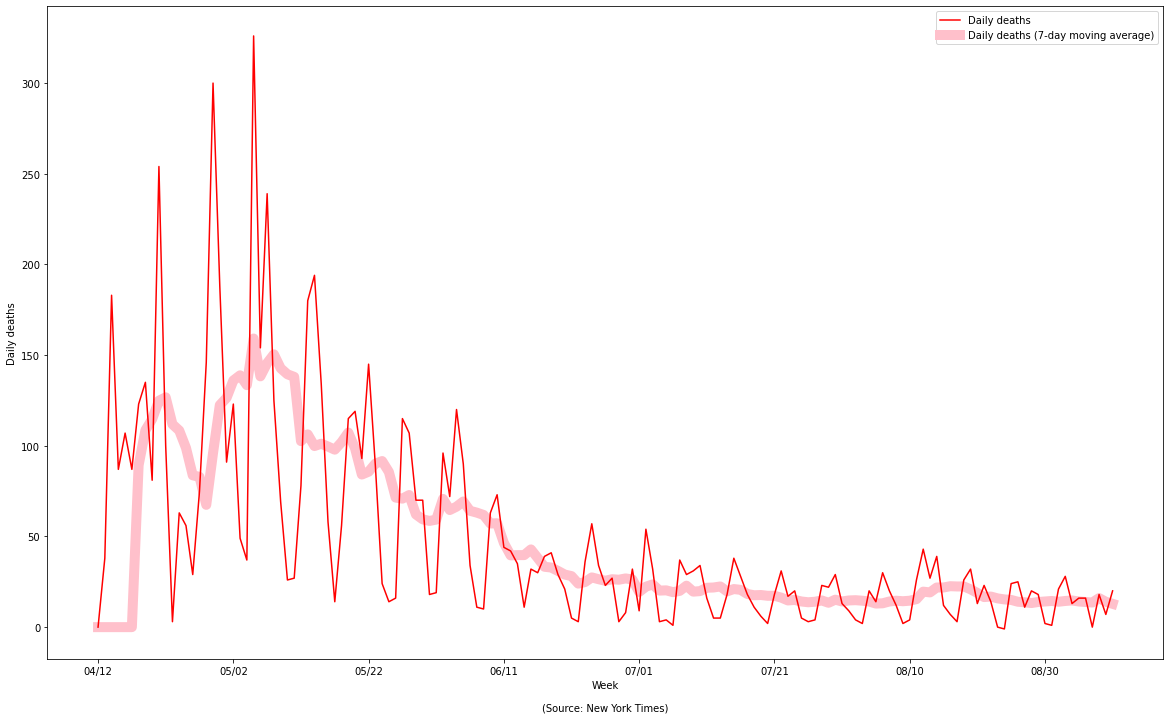

In [24]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-deaths-daily.png");

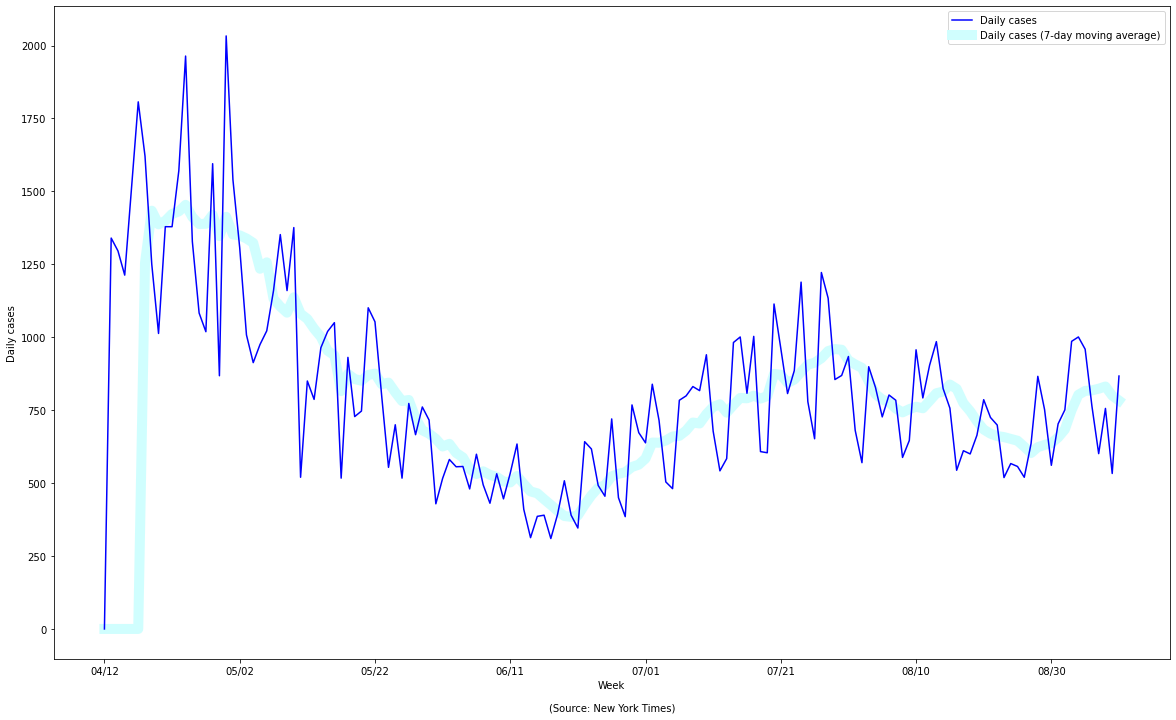

In [25]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-cases-daily.png");

#### New York

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5e26d90>)

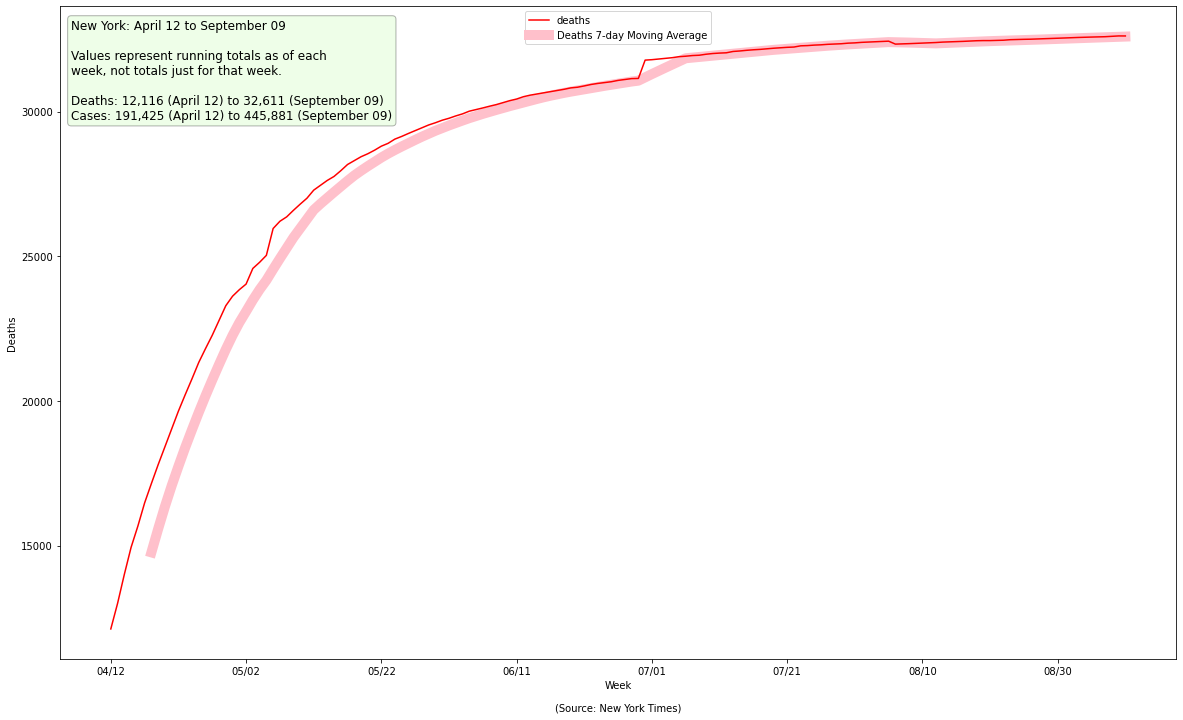

In [26]:
plot_state(df_states, SOURCE, 'New York', moving_average=True,
           image_file='nyt-ny-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5da7e80>)

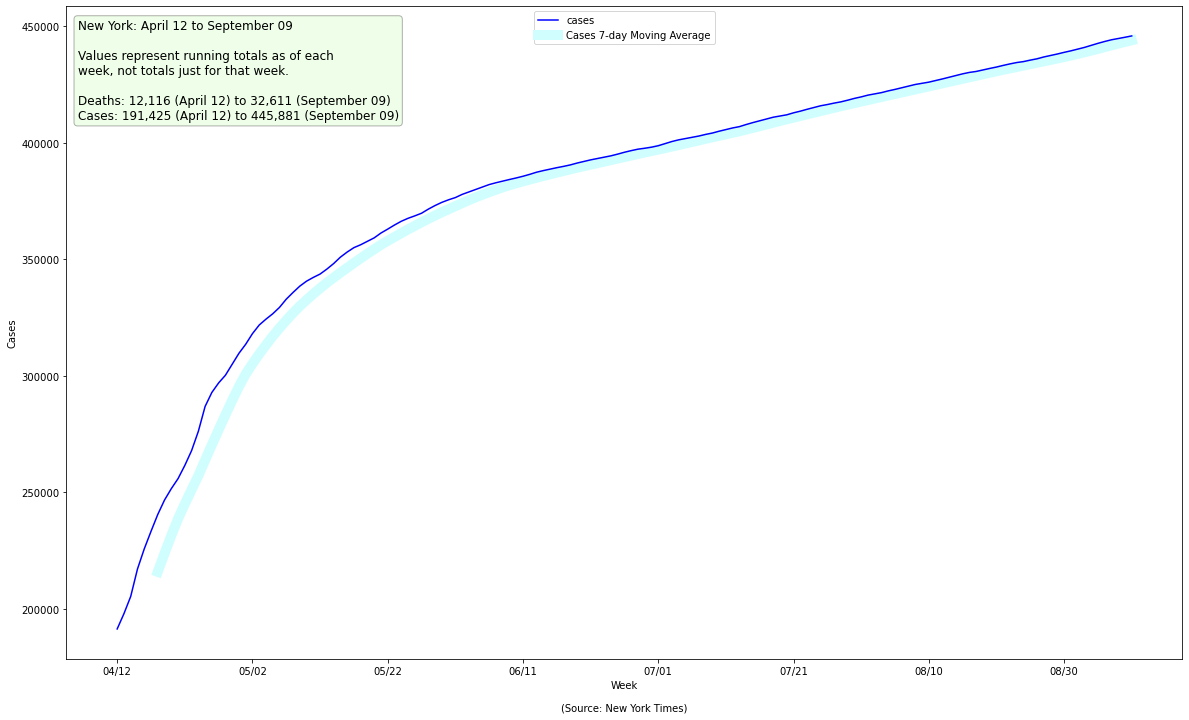

In [27]:
plot_state(df_states, SOURCE, 'New York', moving_average=True,
           image_file='nyt-ny-cases.png', metrics={MetricType.CASES})

#### New Jersey

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5d22e20>)

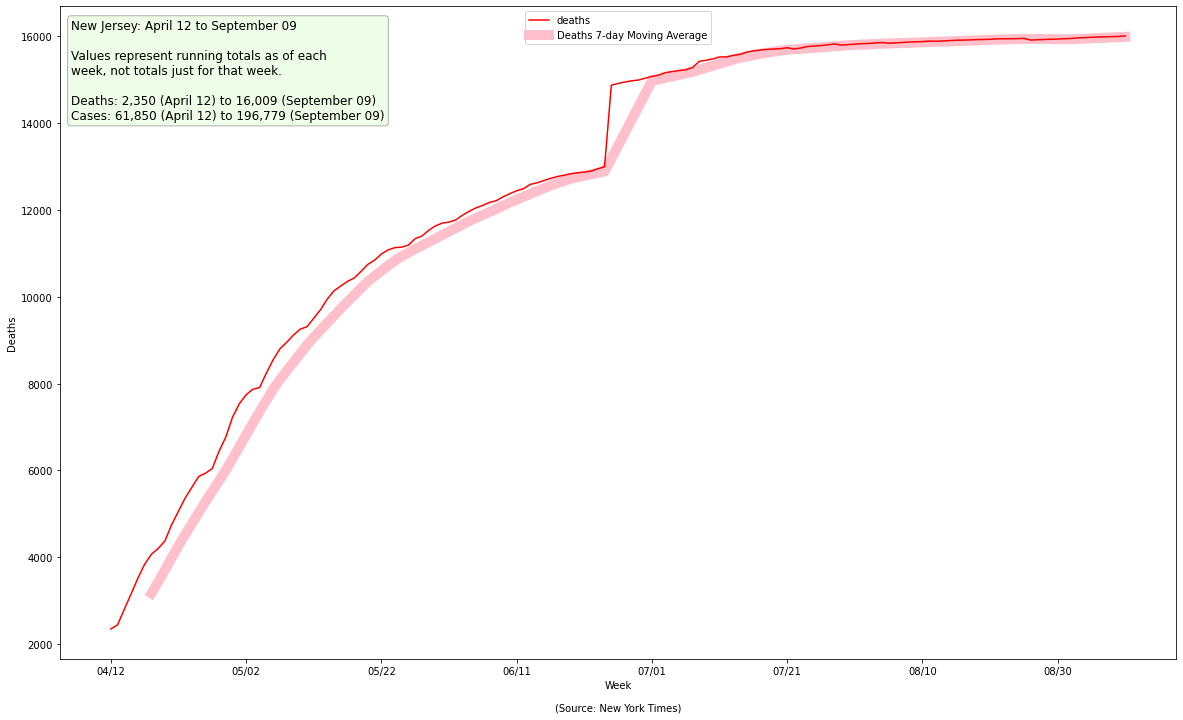

In [28]:
plot_state(df_states, SOURCE, 'New Jersey', moving_average=True,
           image_file='nyt-nj-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5cb0c70>)

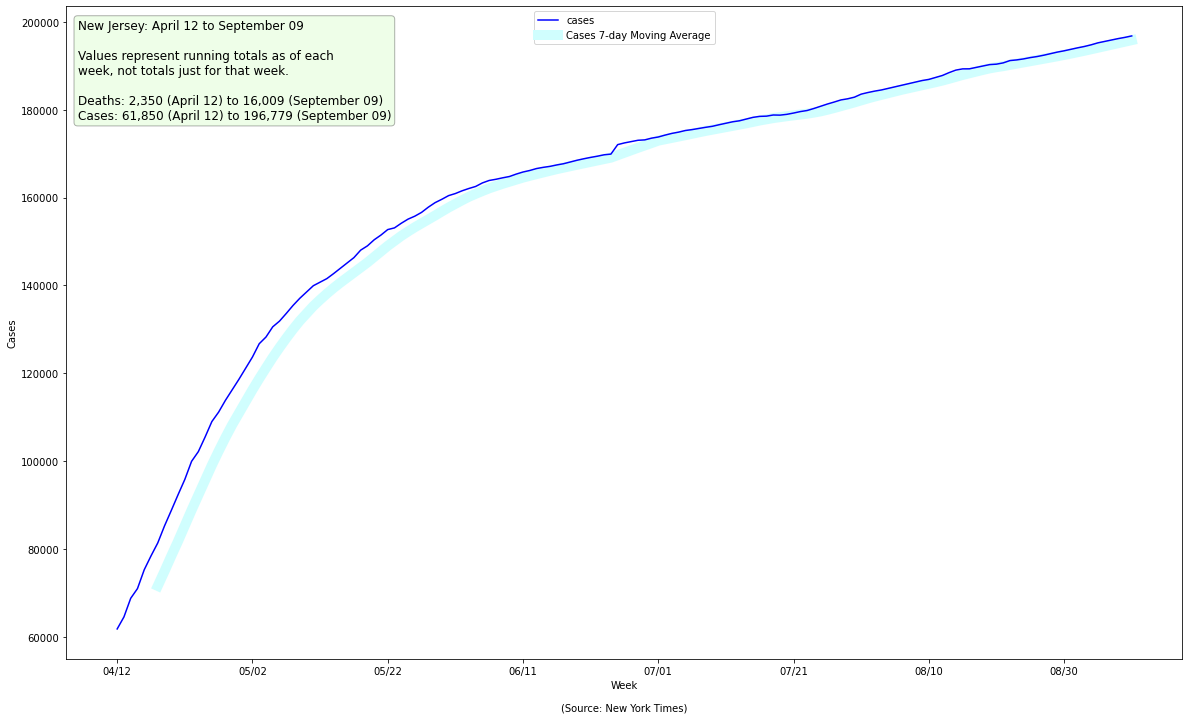

In [29]:
plot_state(df_states, SOURCE, 'New Jersey', moving_average=True,
           image_file='nyt-nj-cases.png', metrics={MetricType.CASES})

#### Washington

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5c5cd90>)

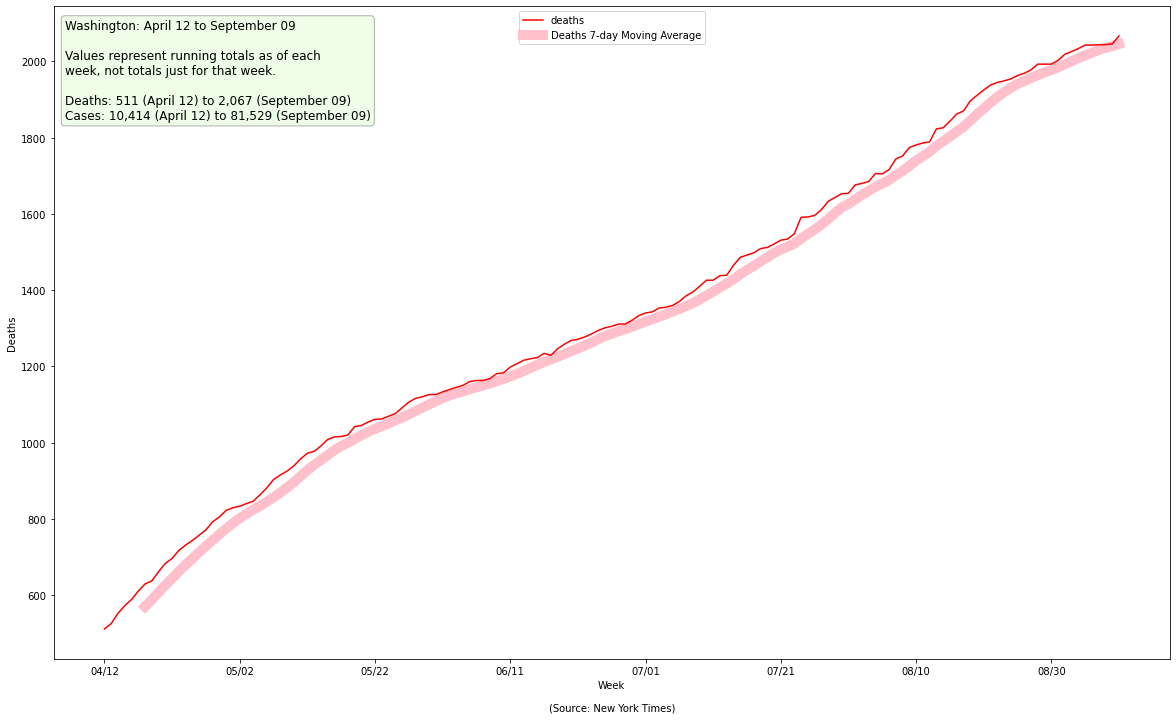

In [30]:
plot_state(df_states, SOURCE, 'Washington', moving_average=True,
           image_file='nyt-wa-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5b8ff10>)

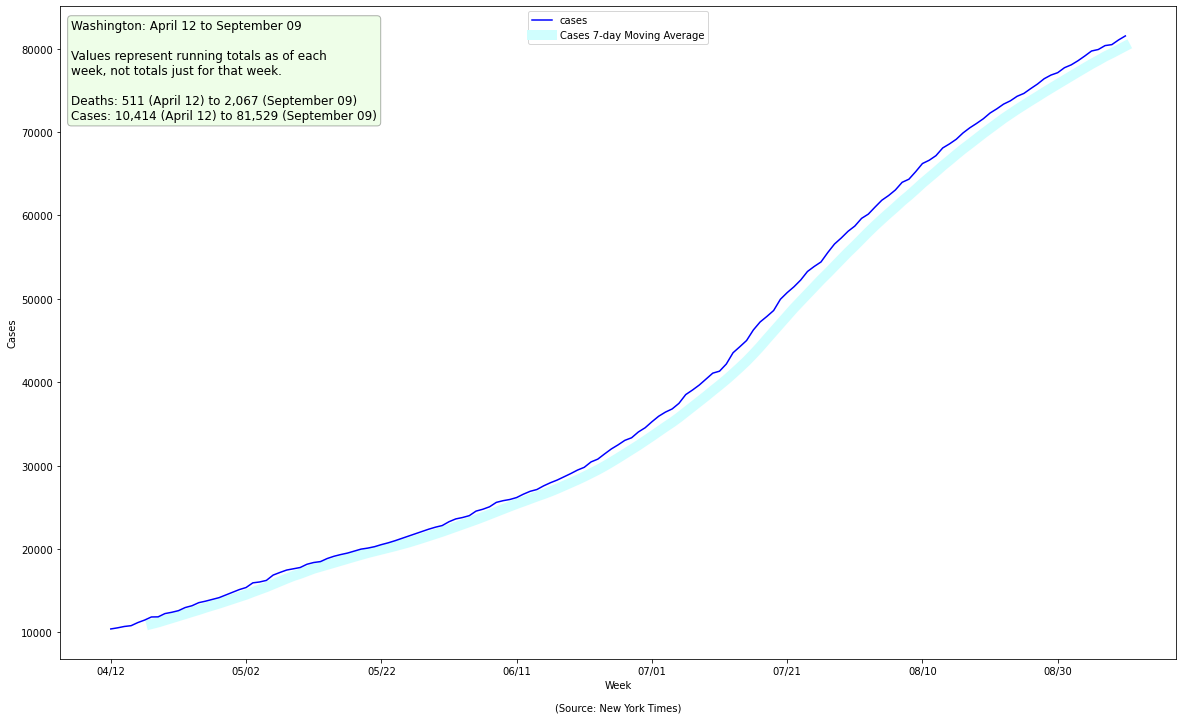

In [31]:
plot_state(df_states, SOURCE, 'Washington', moving_average=True,
           image_file='nyt-wa-cases.png', metrics={MetricType.CASES})

#### Delaware

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5b4a7f0>)

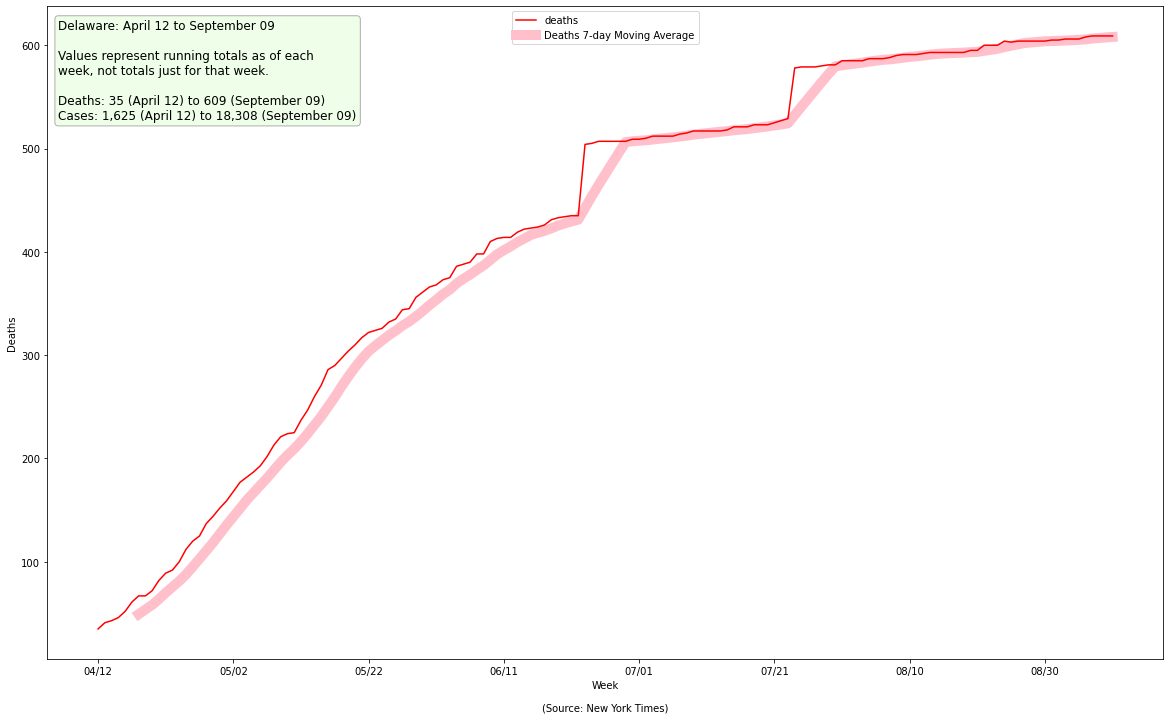

In [32]:
plot_state(df_states, SOURCE, 'Delaware', moving_average=True,
           image_file='nyt-de-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5ca8fd0>)

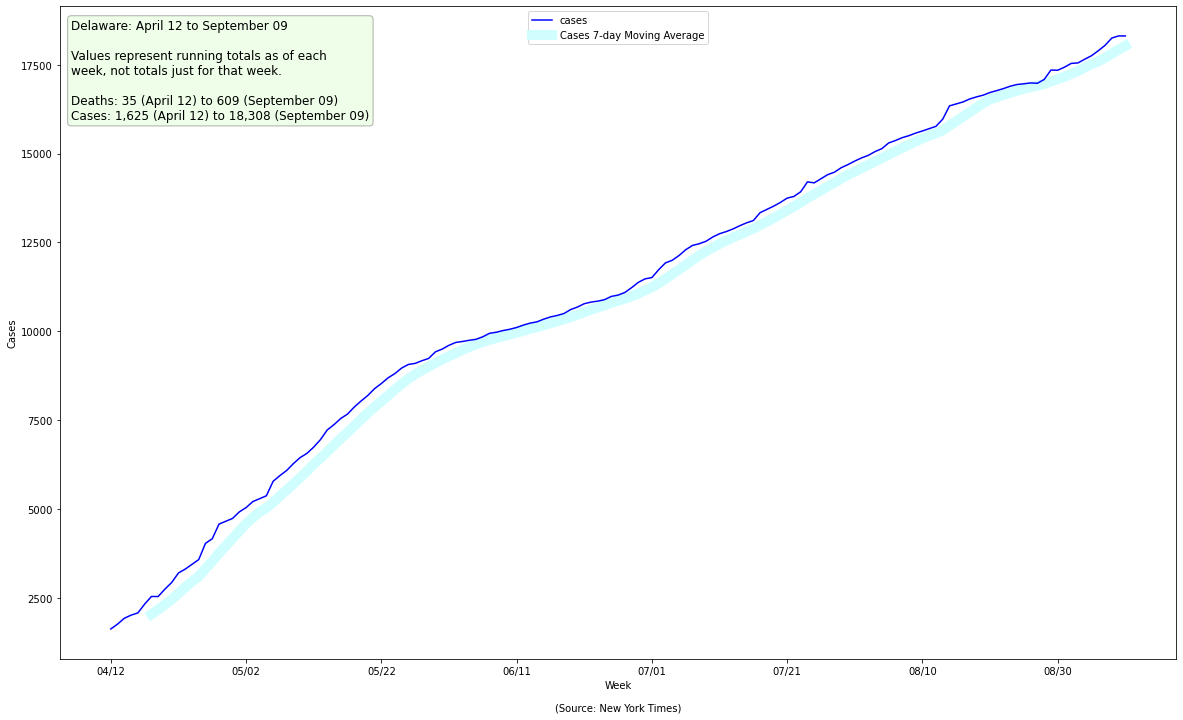

In [33]:
plot_state(df_states, SOURCE, 'Delaware', moving_average=True,
           image_file='nyt-de-cases.png', metrics={MetricType.CASES})

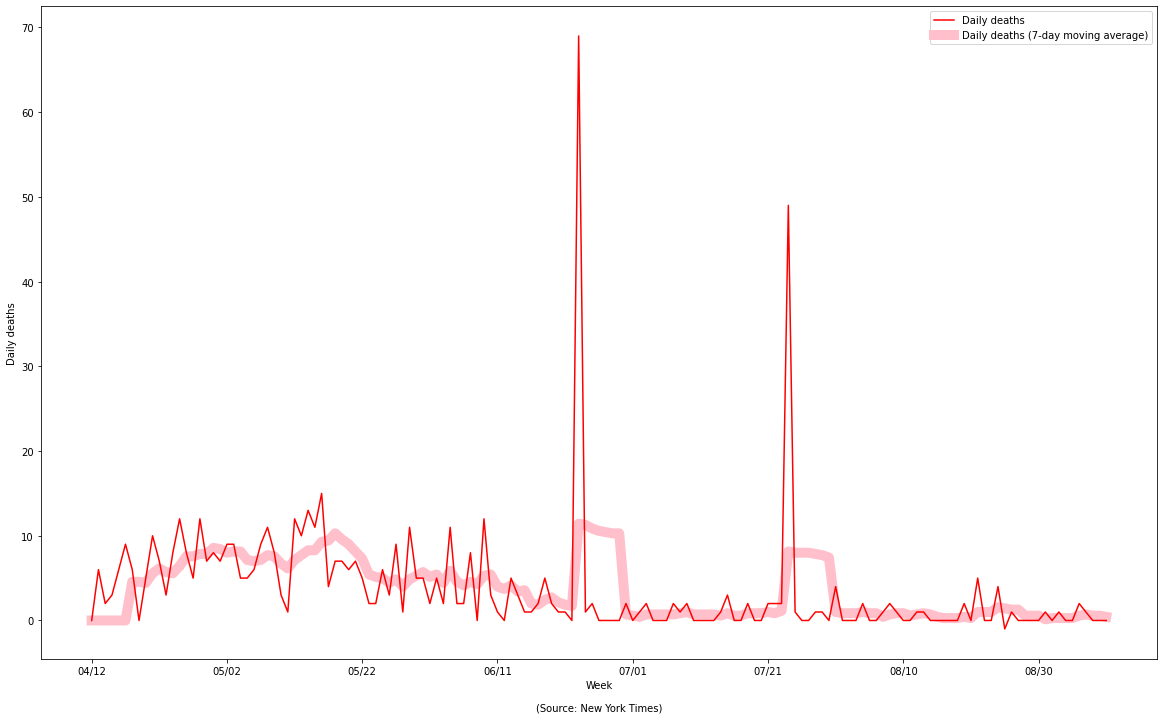

In [34]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Delaware',
                 moving_average=True,
                 image_file="jhu-de-deaths-daily.png");

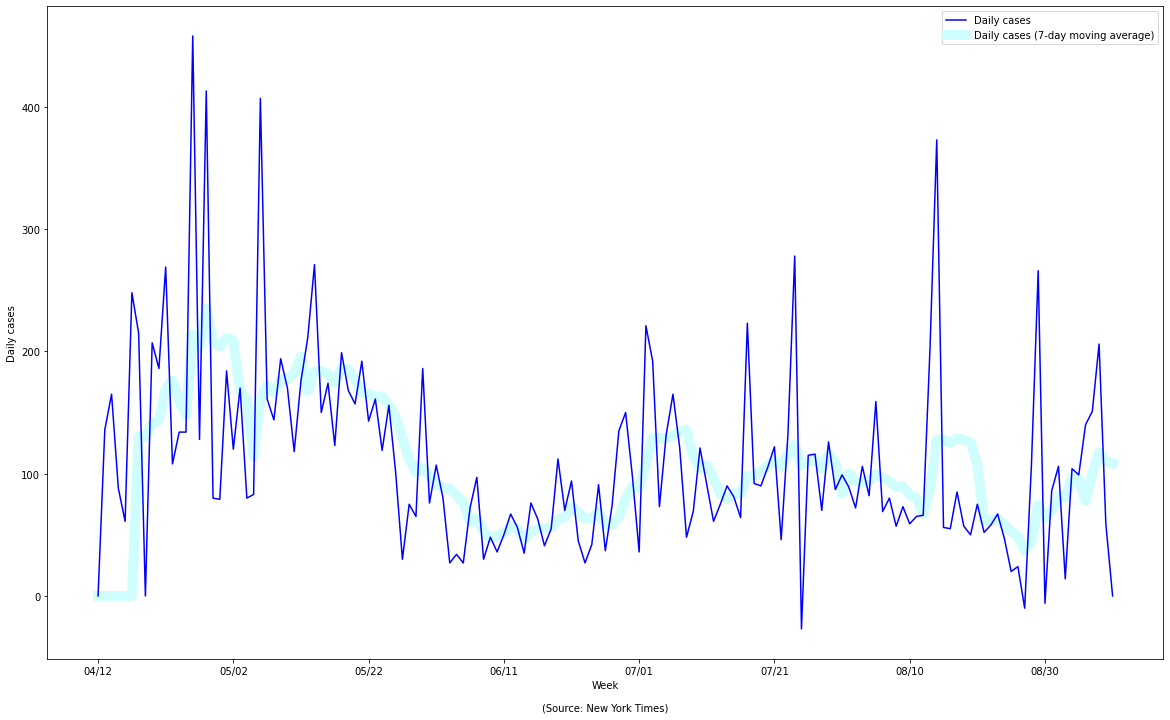

In [35]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Delaware',
                 moving_average=True,
                 image_file="jhu-de-cases-daily.png");

#### Texas

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5b312e0>)

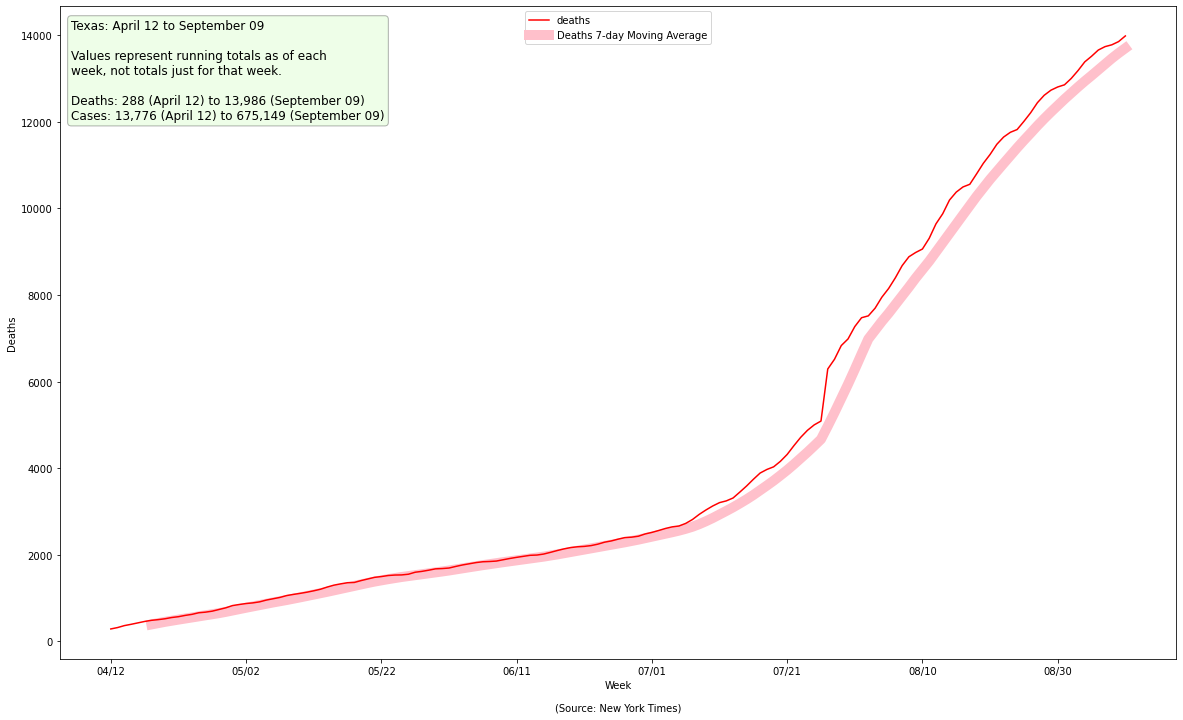

In [36]:
plot_state(df_states, SOURCE, 'Texas', moving_average=True,
           image_file='nyt-tx-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5b31970>)

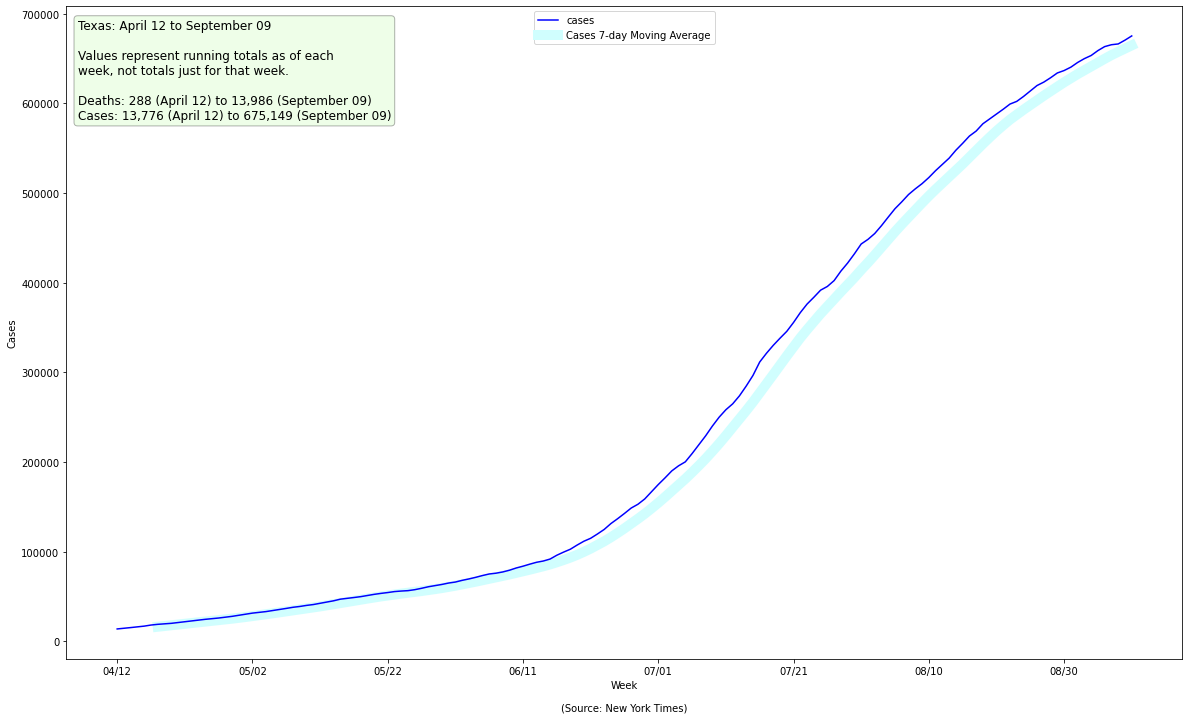

In [37]:
plot_state(df_states, SOURCE, 'Texas', moving_average=True,
           image_file='nyt-tx-cases.png', metrics={MetricType.CASES})

#### Georgia

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5a4e2b0>)

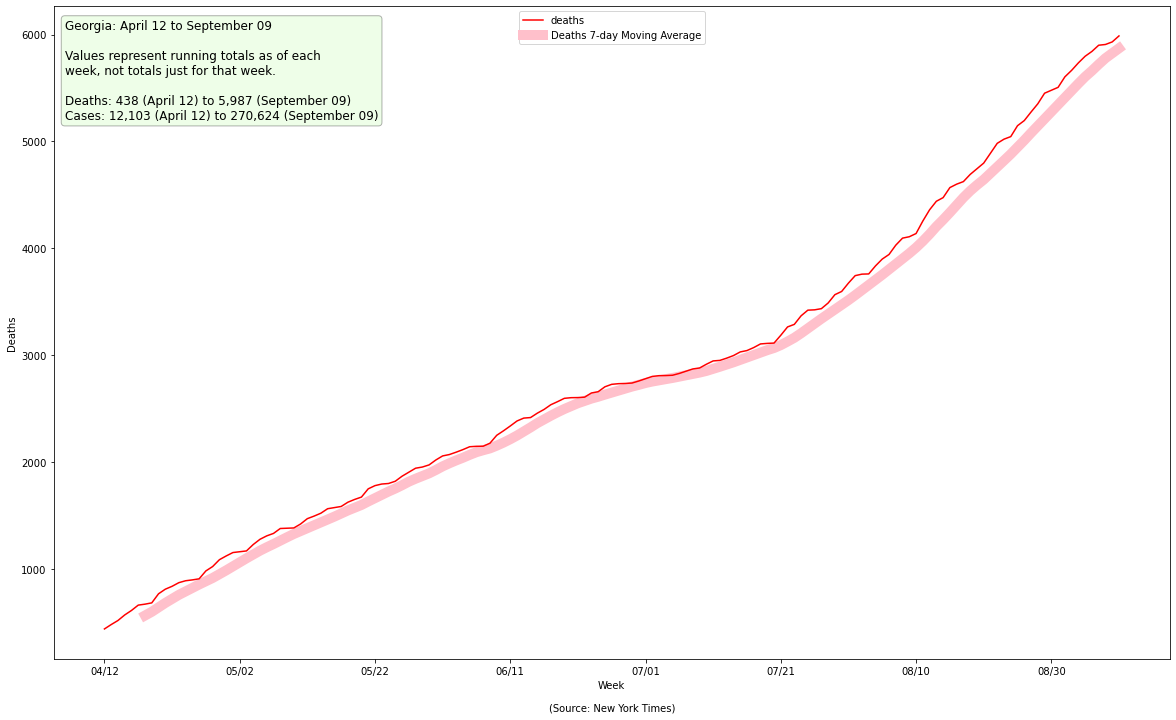

In [38]:
plot_state(df_states, SOURCE, 'Georgia', moving_average=True,
           image_file='nyt-ga-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab59fbac0>)

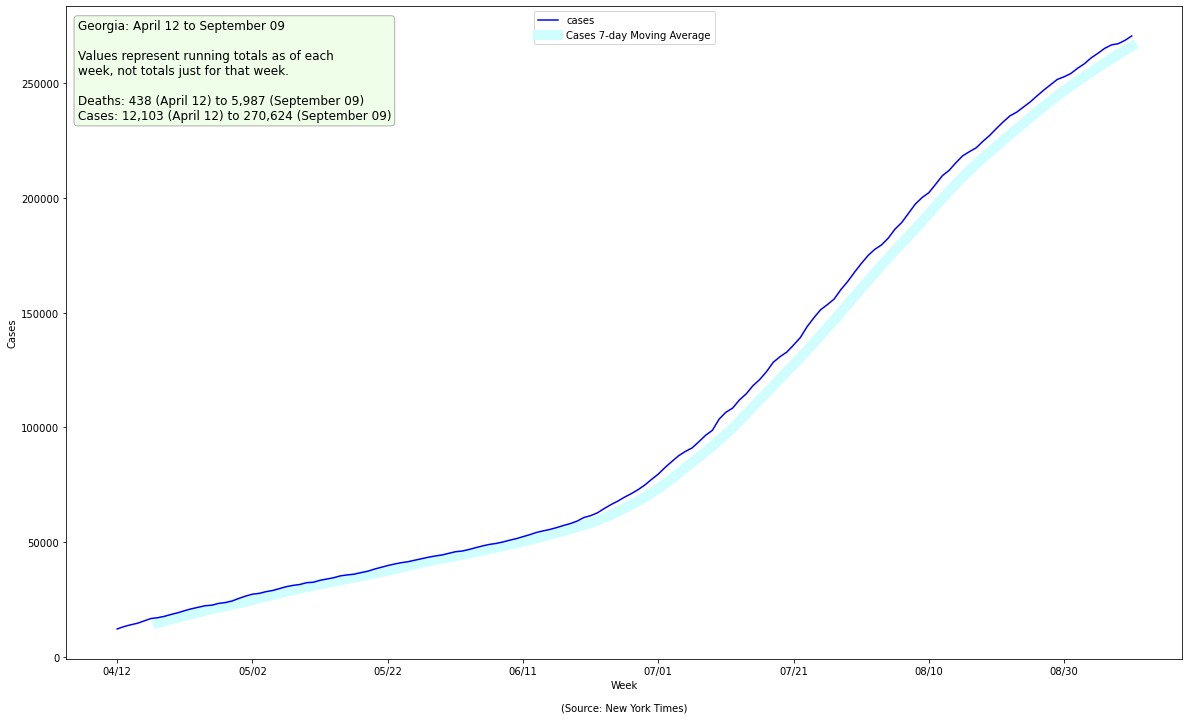

In [39]:
plot_state(df_states, SOURCE, 'Georgia', moving_average=True,
           image_file='nyt-ga-cases.png', metrics={MetricType.CASES})

#### Mississippi

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab596aa00>)

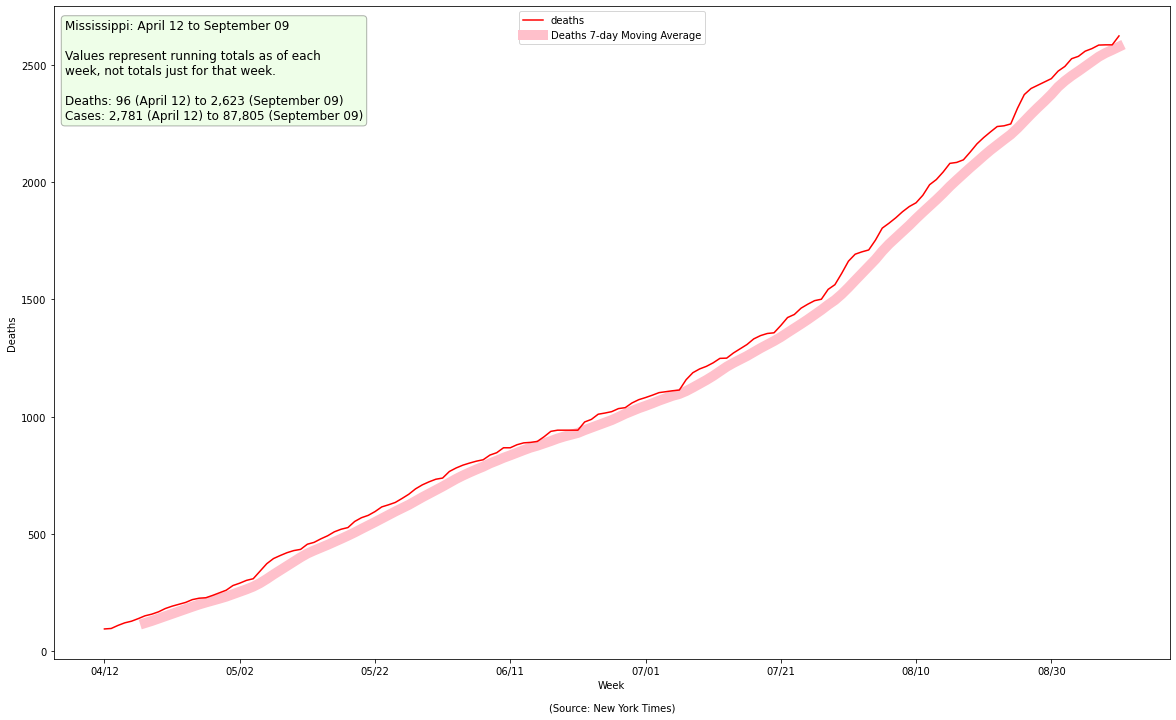

In [40]:
plot_state(df_states, SOURCE, 'Mississippi', moving_average=True,
           image_file='nyt-ms-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab58d0820>)

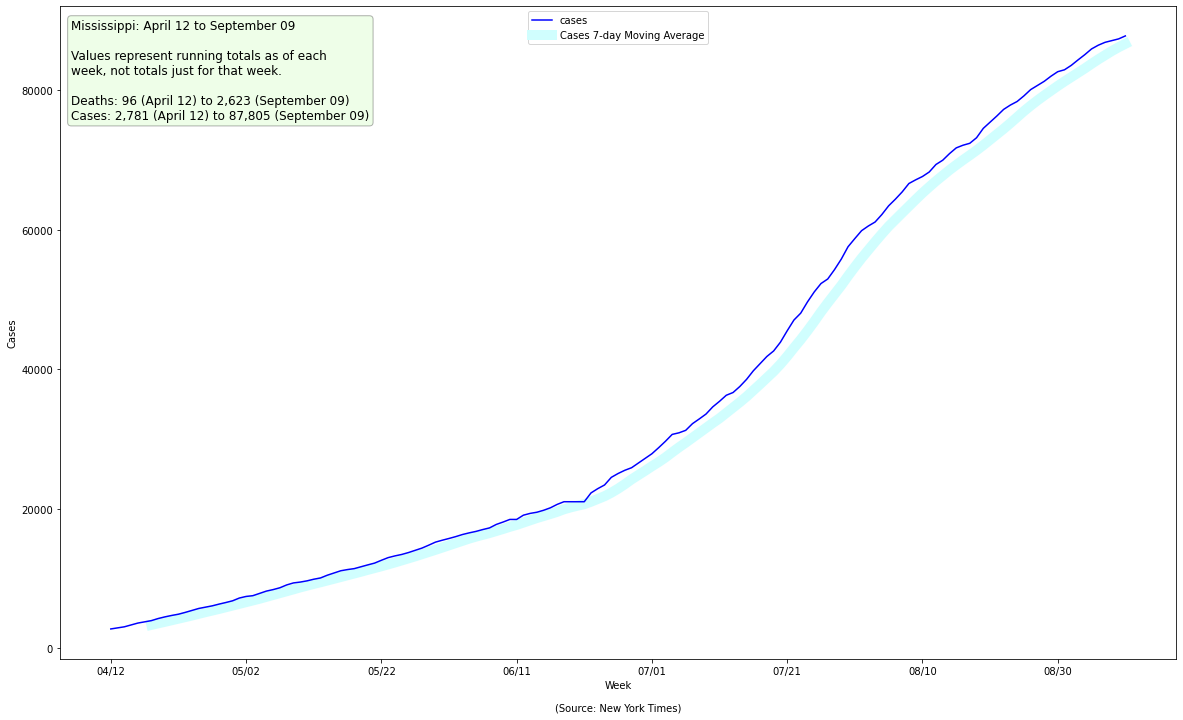

In [41]:
plot_state(df_states, SOURCE, 'Mississippi', moving_average=True,
           image_file='nyt-ms-cases.png', metrics={MetricType.CASES})

#### Arizona

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab58b2a60>)

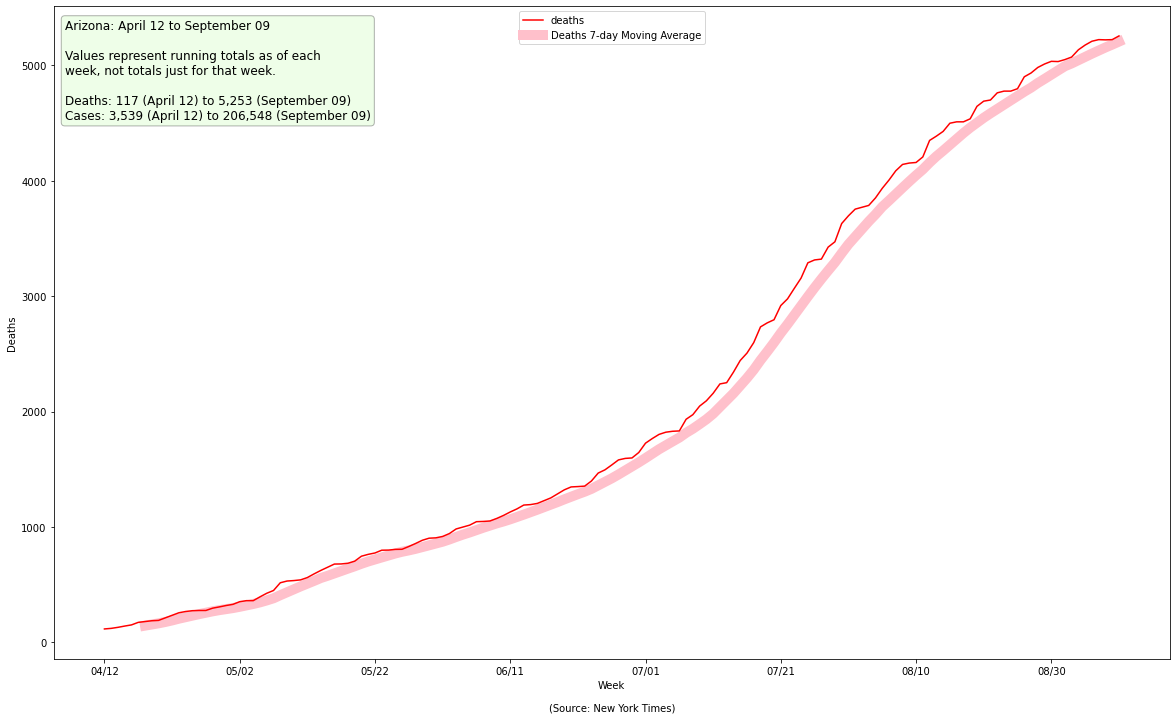

In [42]:
plot_state(df_states, SOURCE, 'Arizona', moving_average=True,
           image_file='nyt-az-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab58b2fa0>)

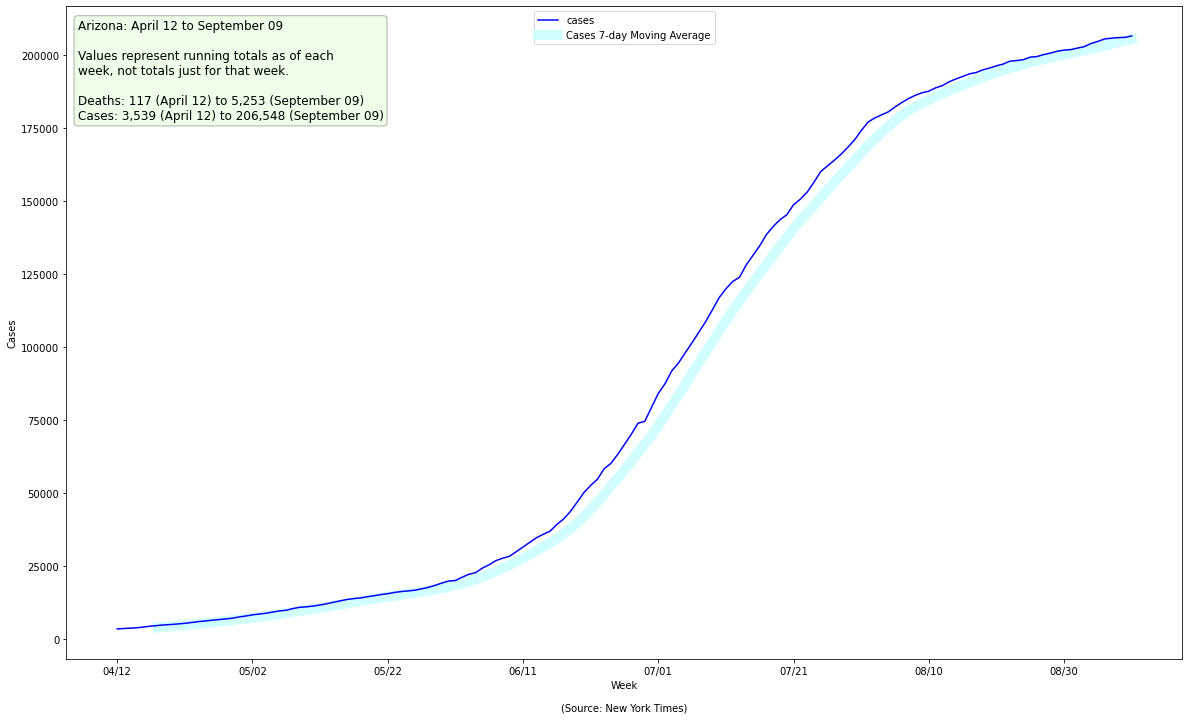

In [43]:
plot_state(df_states, SOURCE, 'Arizona', moving_average=True,
           image_file='nyt-az-cases.png', metrics={MetricType.CASES})

#### Florida

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab58d4d30>)

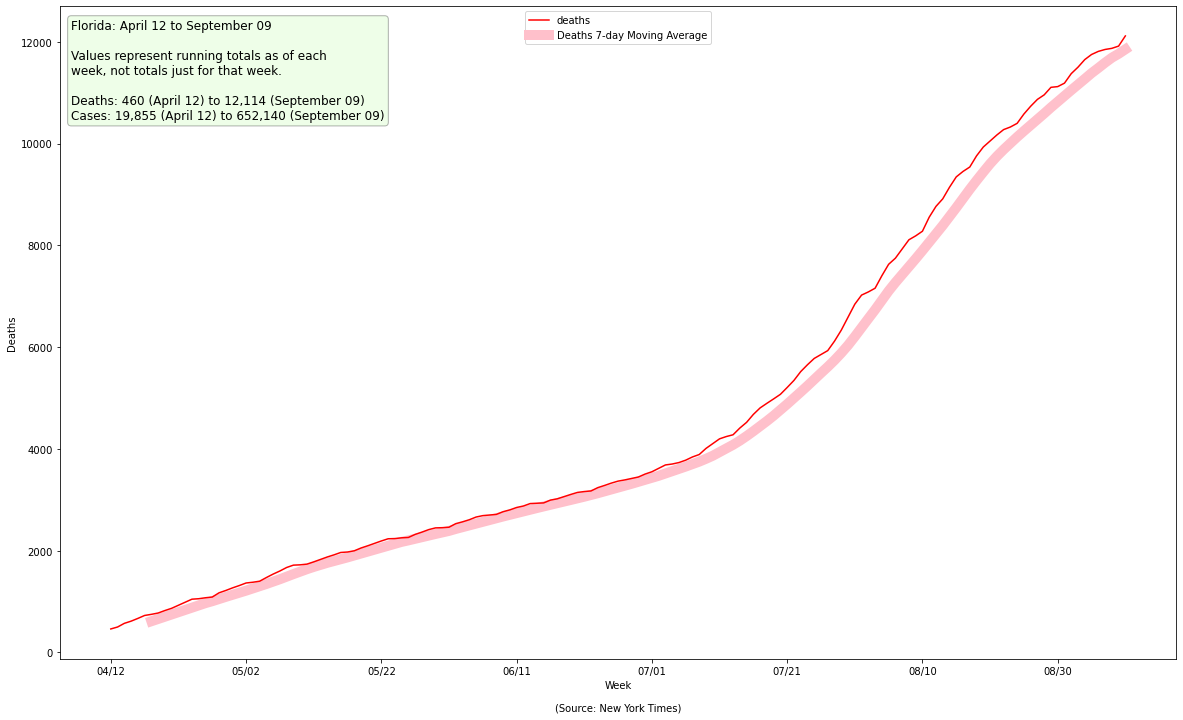

In [44]:
plot_state(df_states, SOURCE, 'Florida', moving_average=True,
           image_file='nyt-fl-deaths.png', metrics={MetricType.DEATHS})

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2aca08eb80>)

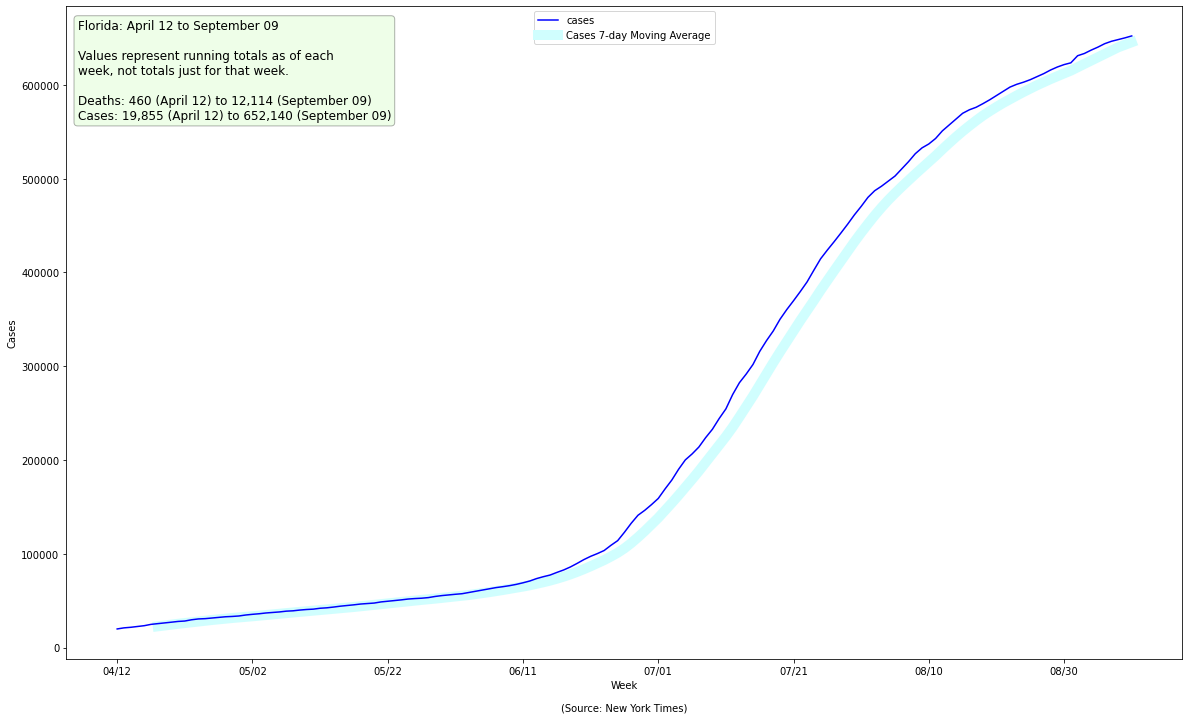

In [45]:
plot_state(df_states, SOURCE, 'Florida', moving_average=True,
           image_file='nyt-fl-cases.png', metrics={MetricType.CASES})

## Multistate

### Northeast states

Data from some of the states that were hardest hit early on.

In [46]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5e41610>)

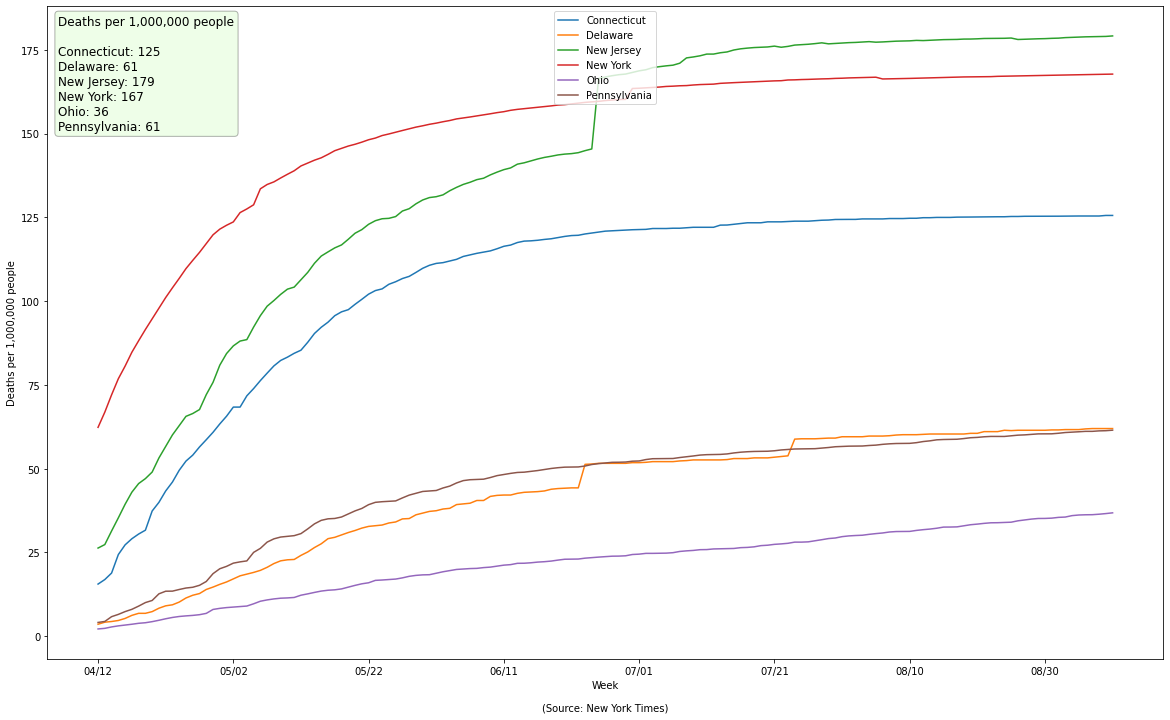

In [47]:
plot_states(df_states, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='upper center', image_file='nyt-ne-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5154430>)

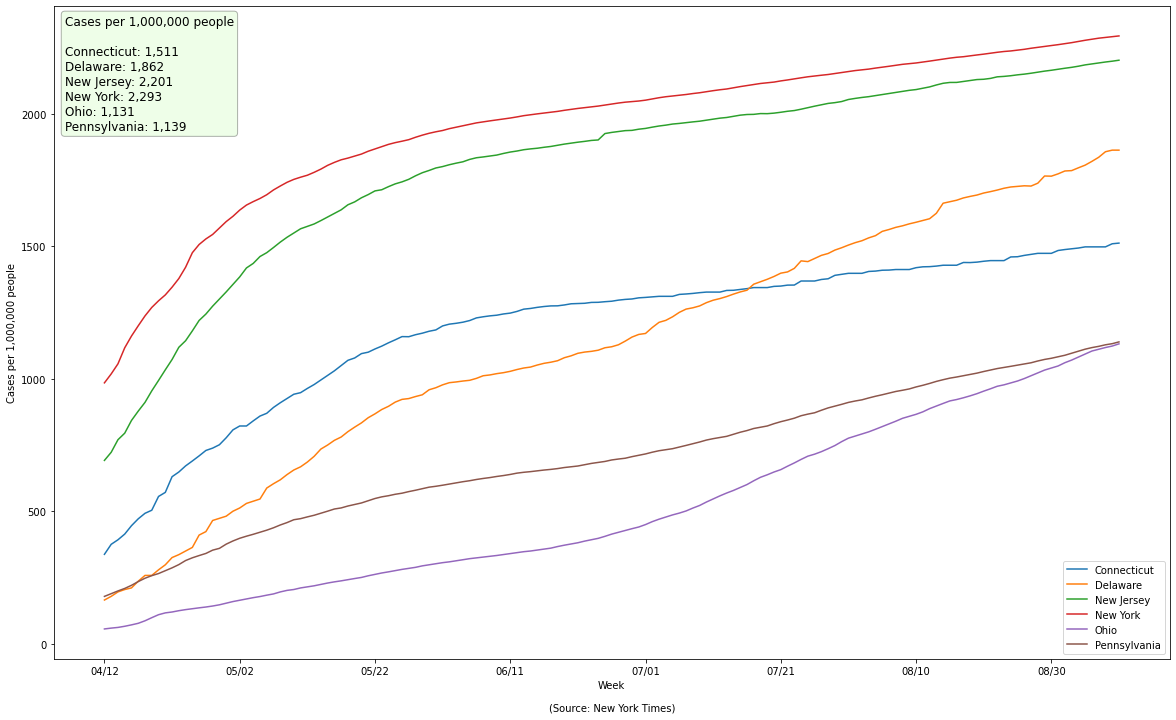

In [48]:
plot_states(df_states, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            legend_loc='lower right', image_file='nyt-ne-states-cases-per-capita.png')

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [49]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5064280>)

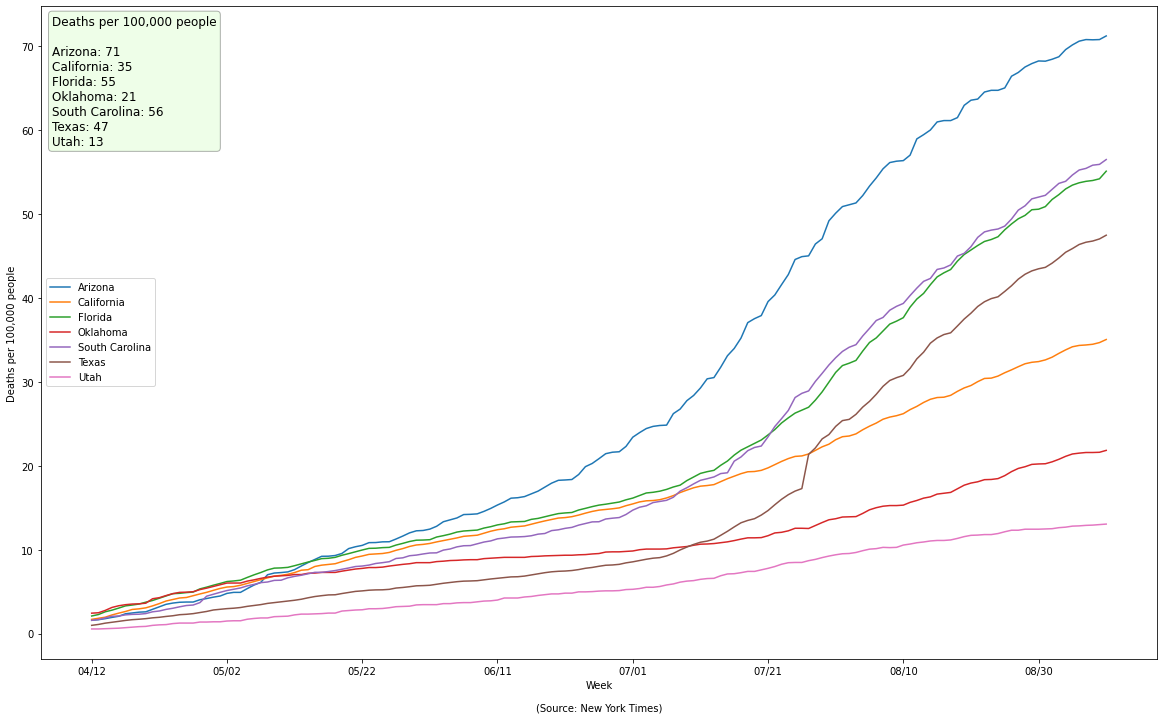

In [50]:
plot_states(df_states, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='nyt-s-sw-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab5039730>)

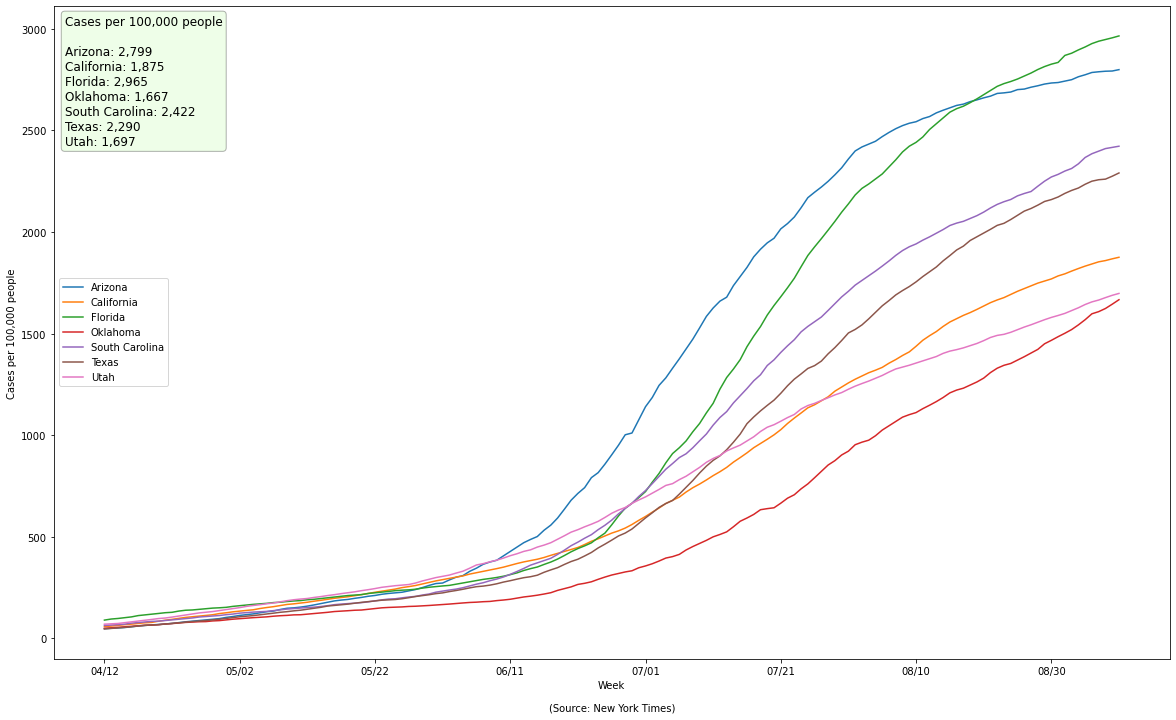

In [51]:
plot_states(df_states, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='nyt-s-sw-states-cases-per-capita.png')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [52]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab4fc6cd0>)

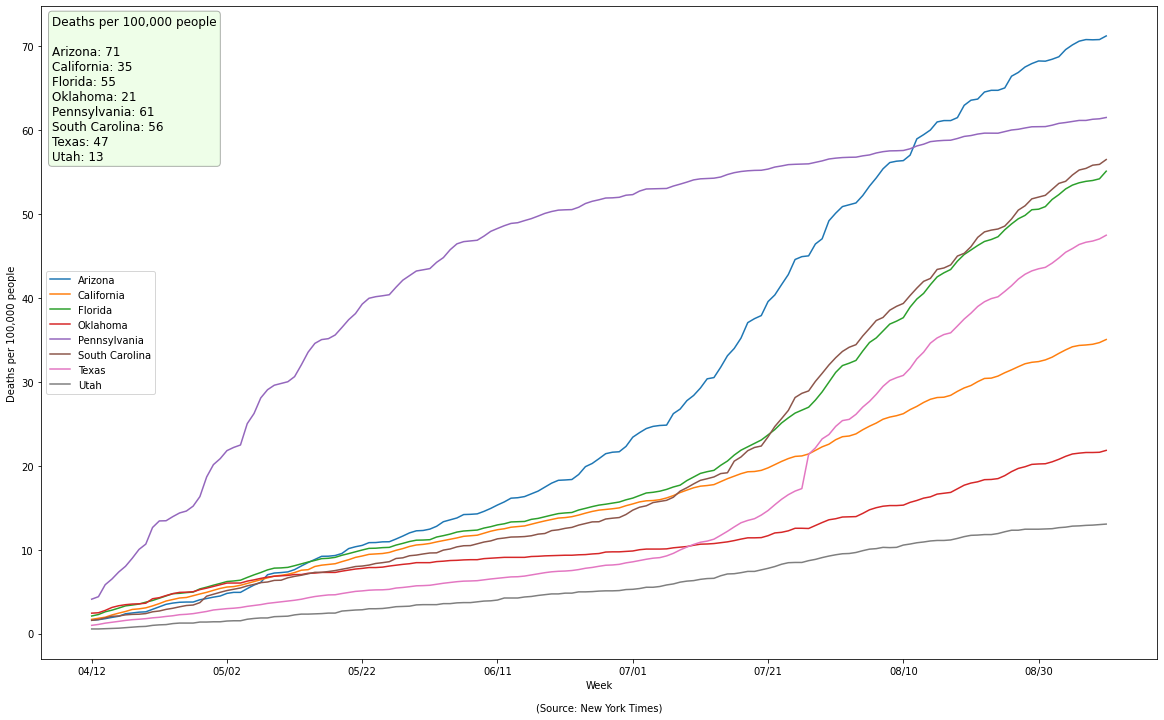

In [53]:
plot_states(df_states, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='nyt-s-sw-states-with-pa-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab4f547c0>)

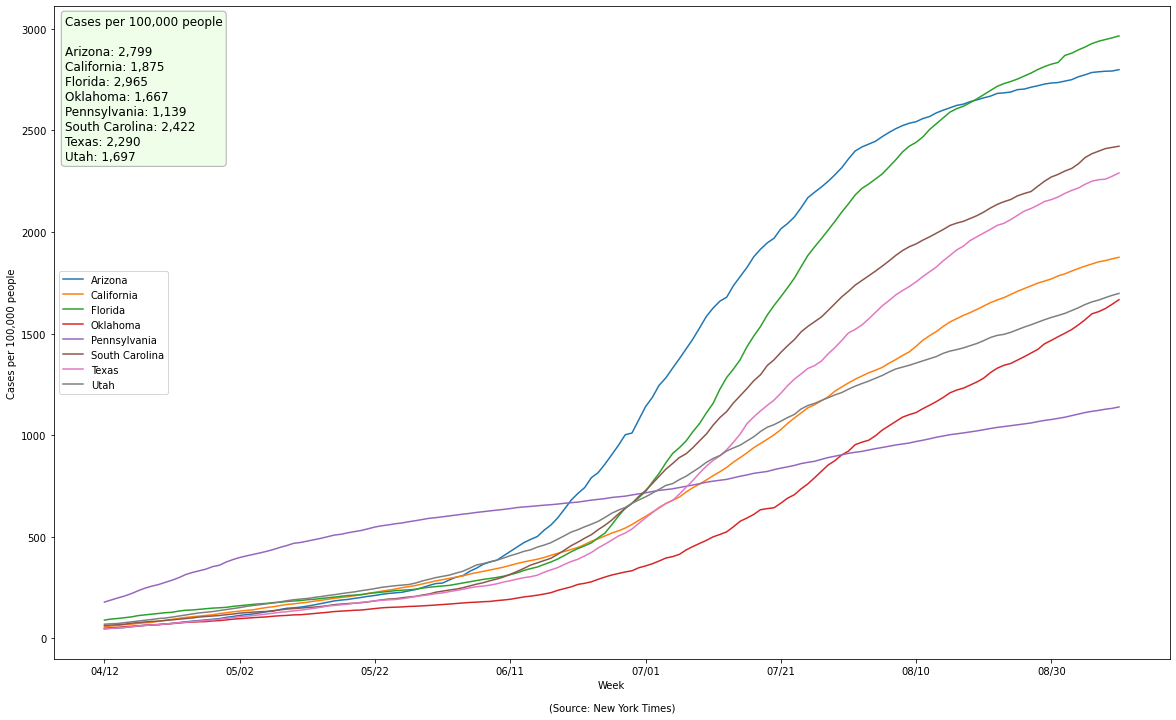

In [54]:
plot_states(df_states, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='nyt-s-sw-states-with-pa-cases-per-capita.png')

## Per-capita rates for all states

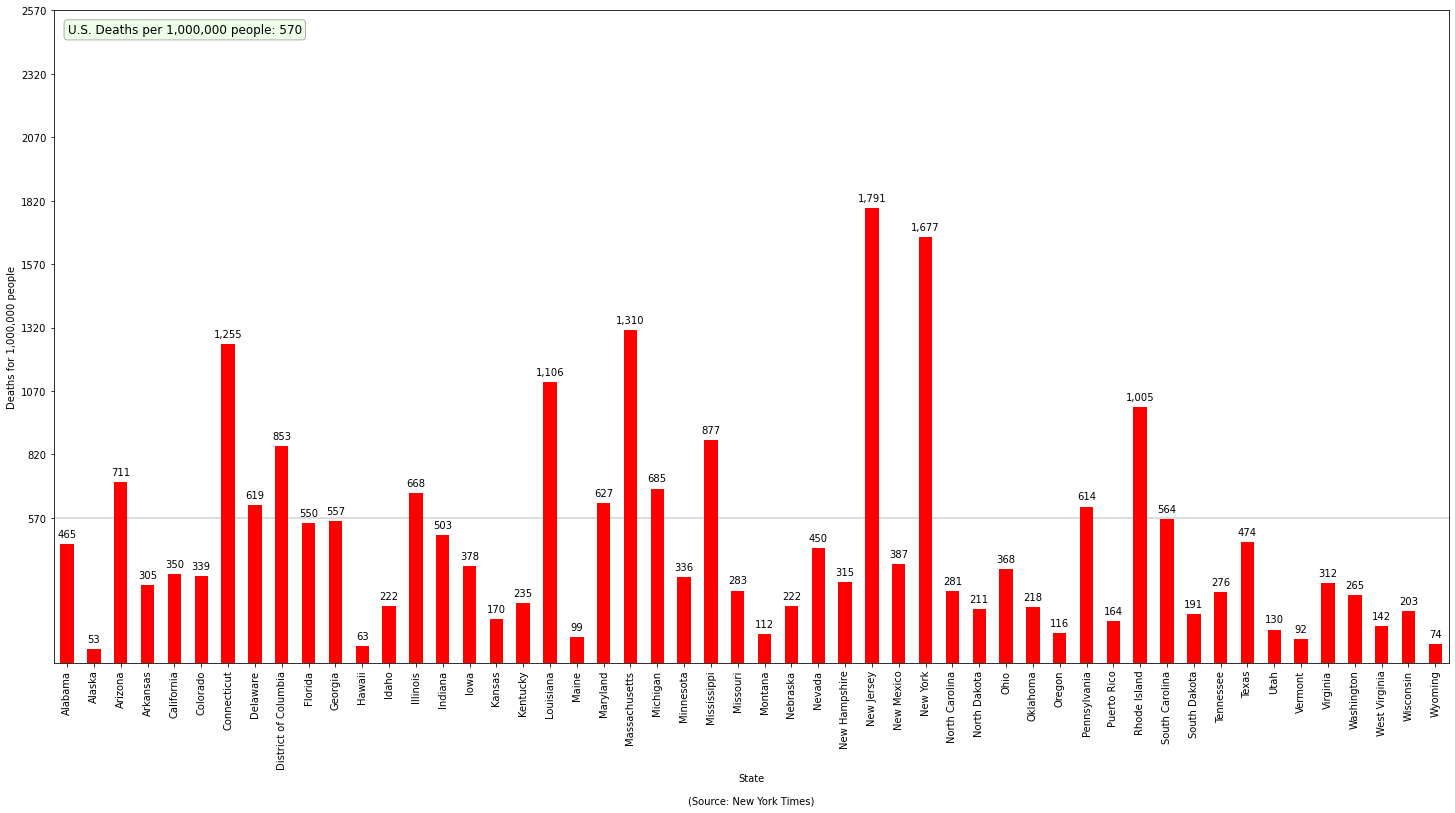

In [55]:
plot_states_per_capita(df_states, SOURCE, populations, image_file='nyt-state-deaths-per-capita.png');

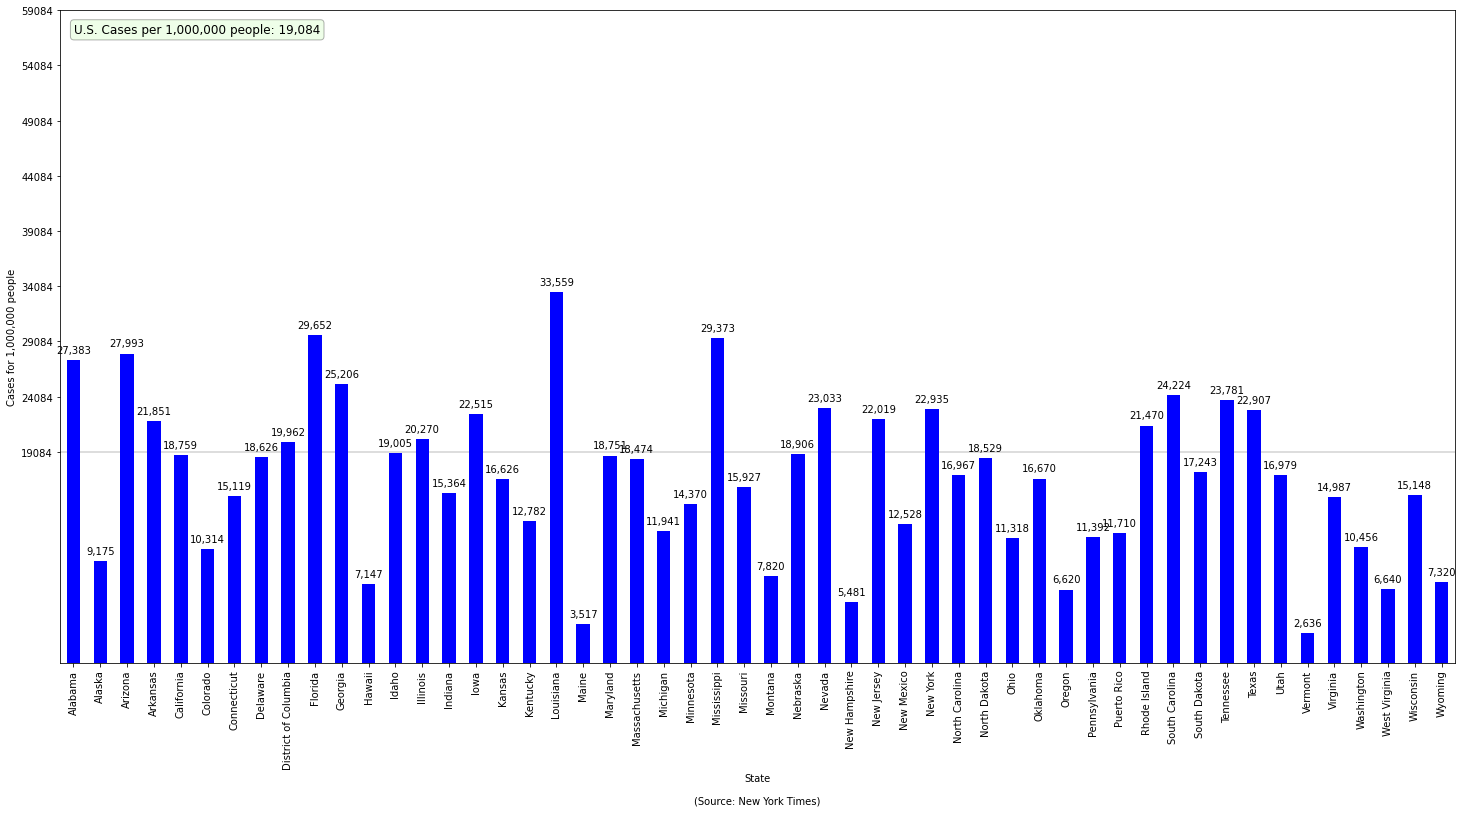

In [56]:
plot_states_per_capita(df_states, SOURCE, populations, metric=MetricType.CASES, image_file='nyt-state-cases-per-capita.png');

## Counties

### Some select Pennsylvania counties

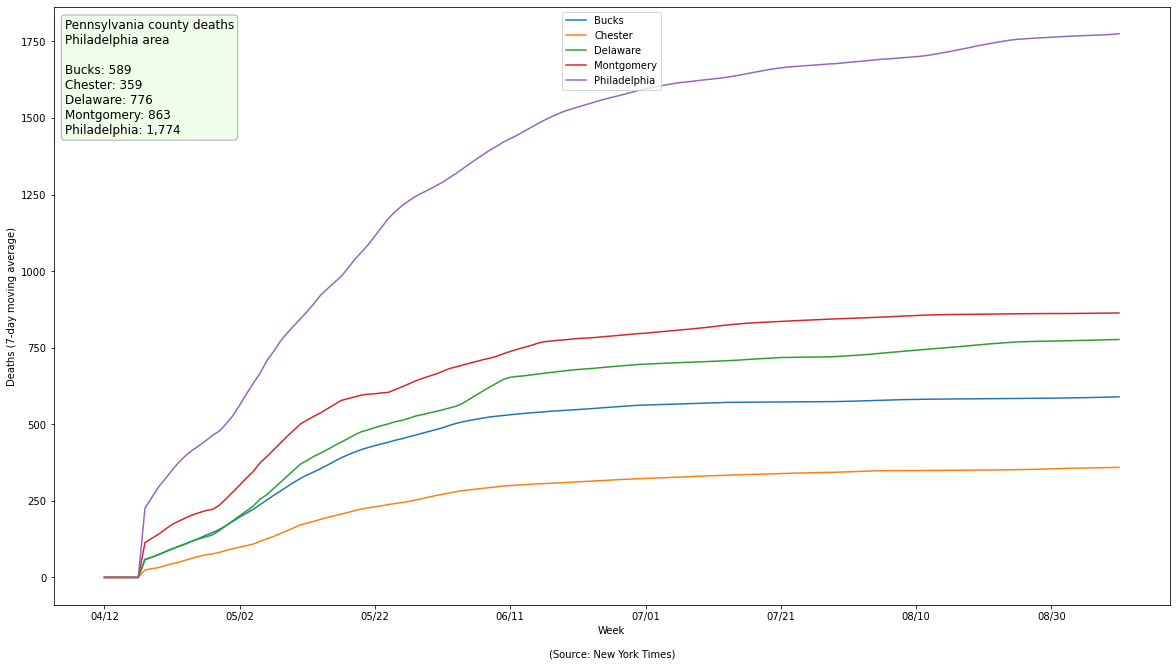

In [57]:
philly_area_counties = ('Montgomery', 'Philadelphia', 'Chester', 'Bucks', 'Delaware')
plot_counties(df_counties, 'Pennsylvania', philly_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.DEATHS, image_file='nyt-pa-phl-area-deaths.png')

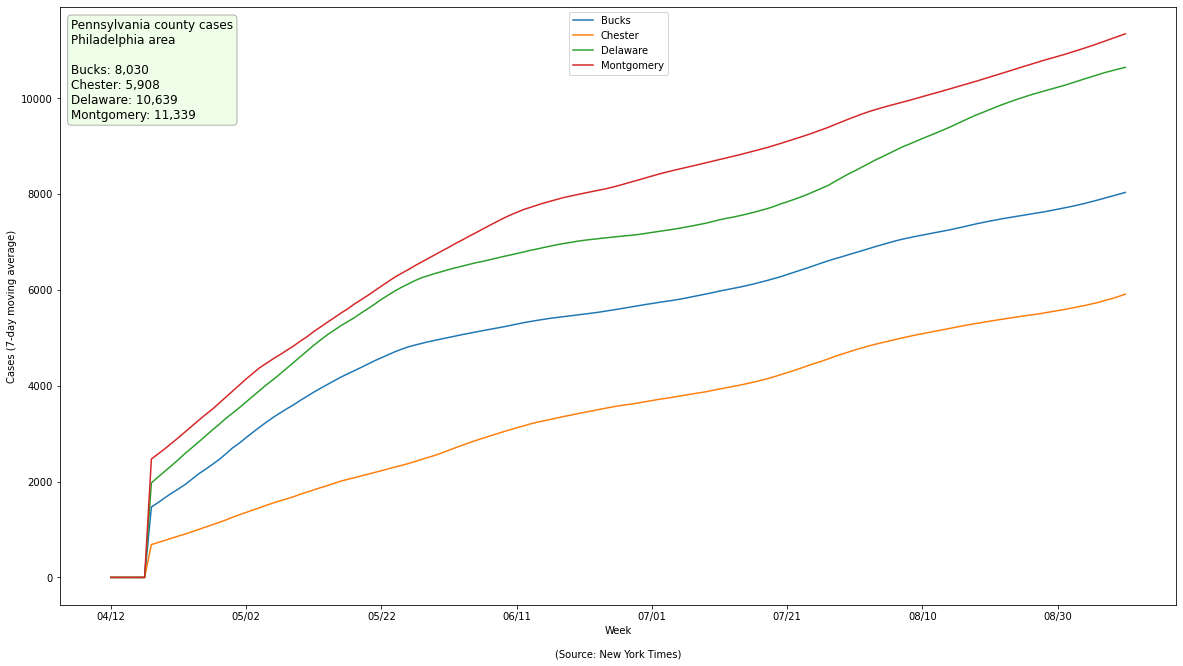

In [58]:
without_philly = set(philly_area_counties) - {'Philadelphia',}
plot_counties(df_counties, 'Pennsylvania', without_philly, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.CASES, image_file='nyt-pa-outside-phl-cases.png')

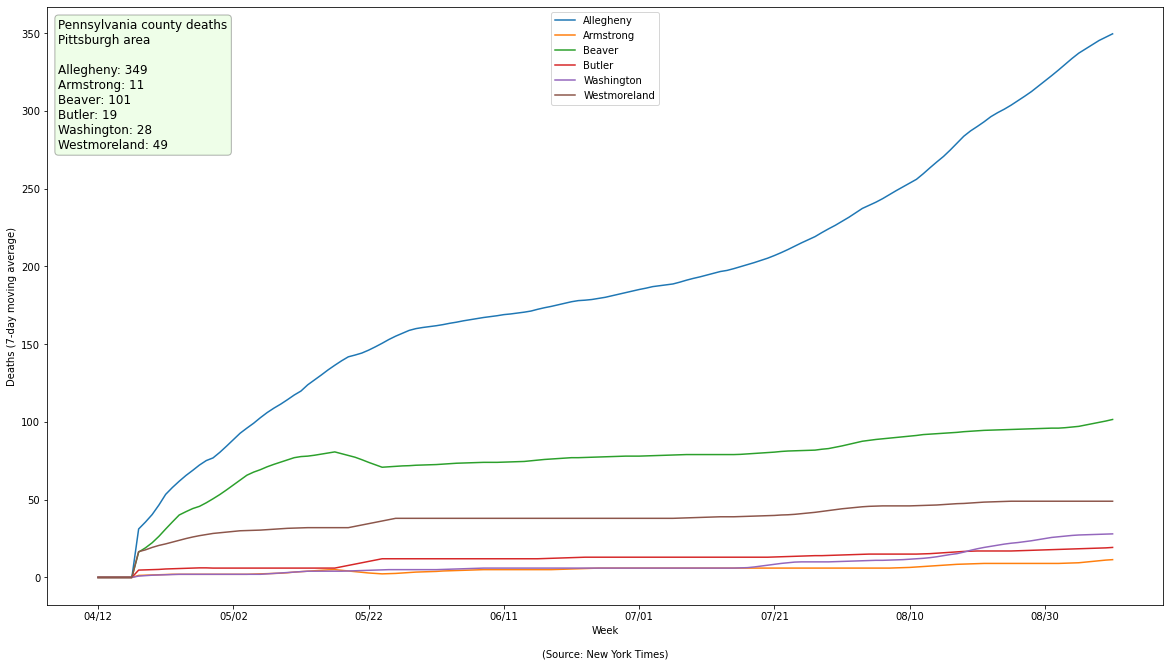

In [59]:
pgh_area_counties = ('Allegheny', 'Butler', 'Beaver',
                     'Washington', 'Westmoreland', 'Armstrong')
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.DEATHS, image_file='nyt-pgh-area-deaths.png')

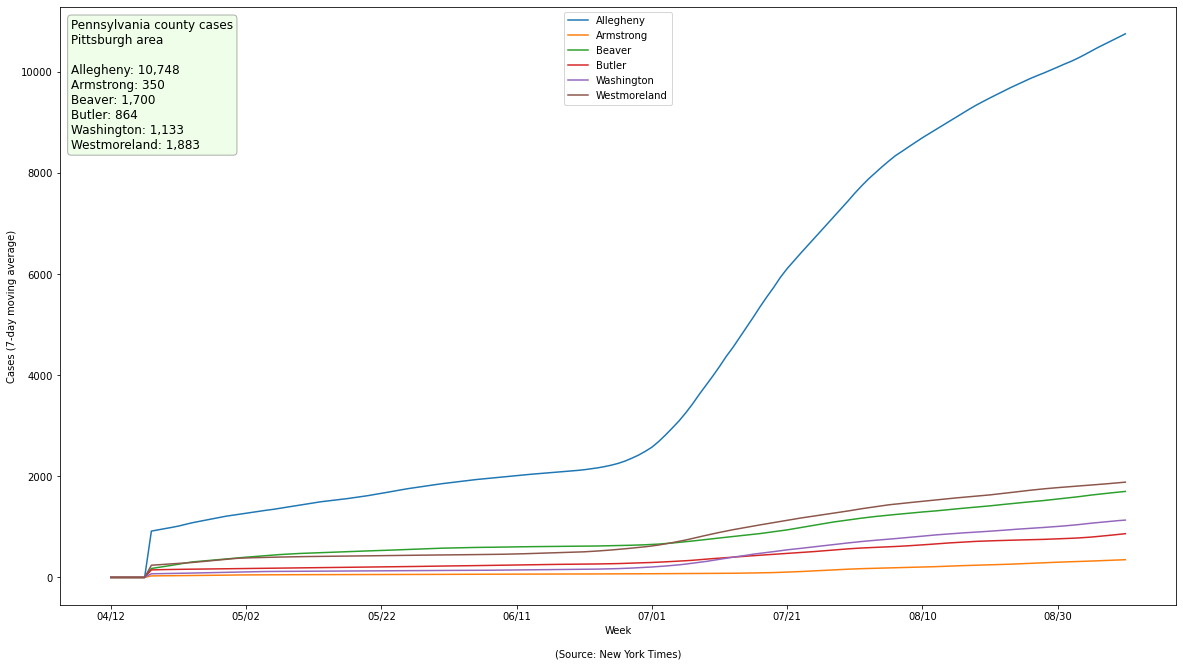

In [60]:
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.CASES, image_file='nyt-pgh-area-cases.png')

#### Some daily stats for certain counties

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab4124f10>)

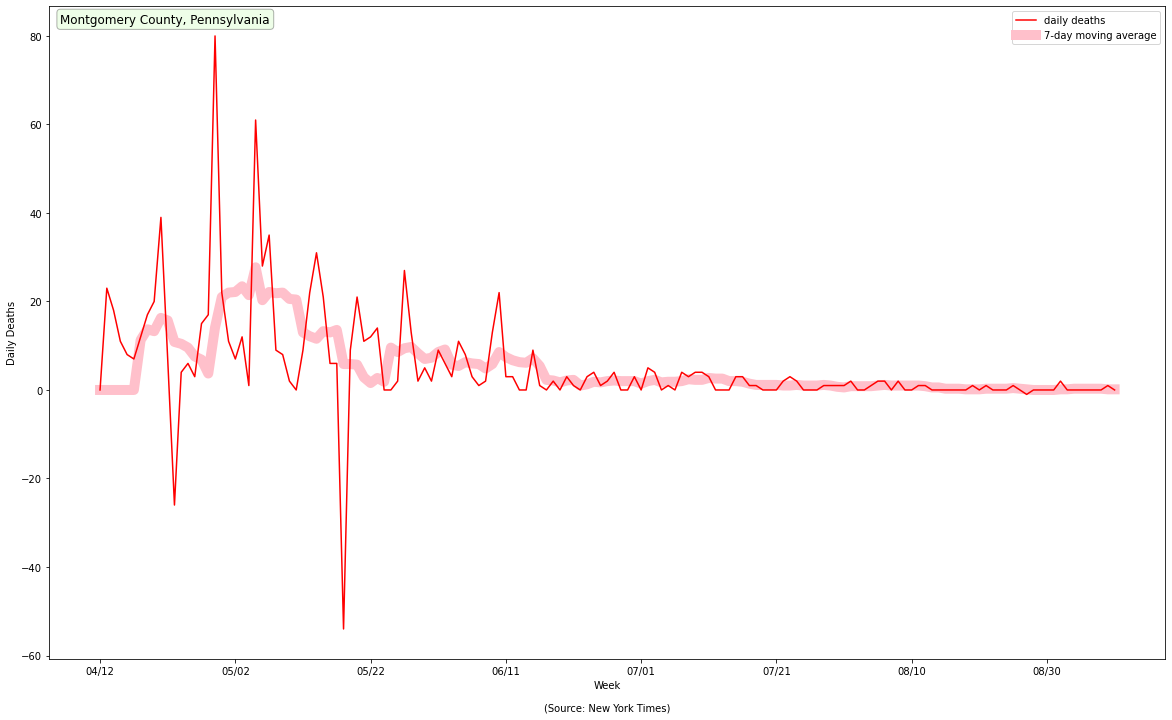

In [61]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-pa-montgomery-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab41876d0>)

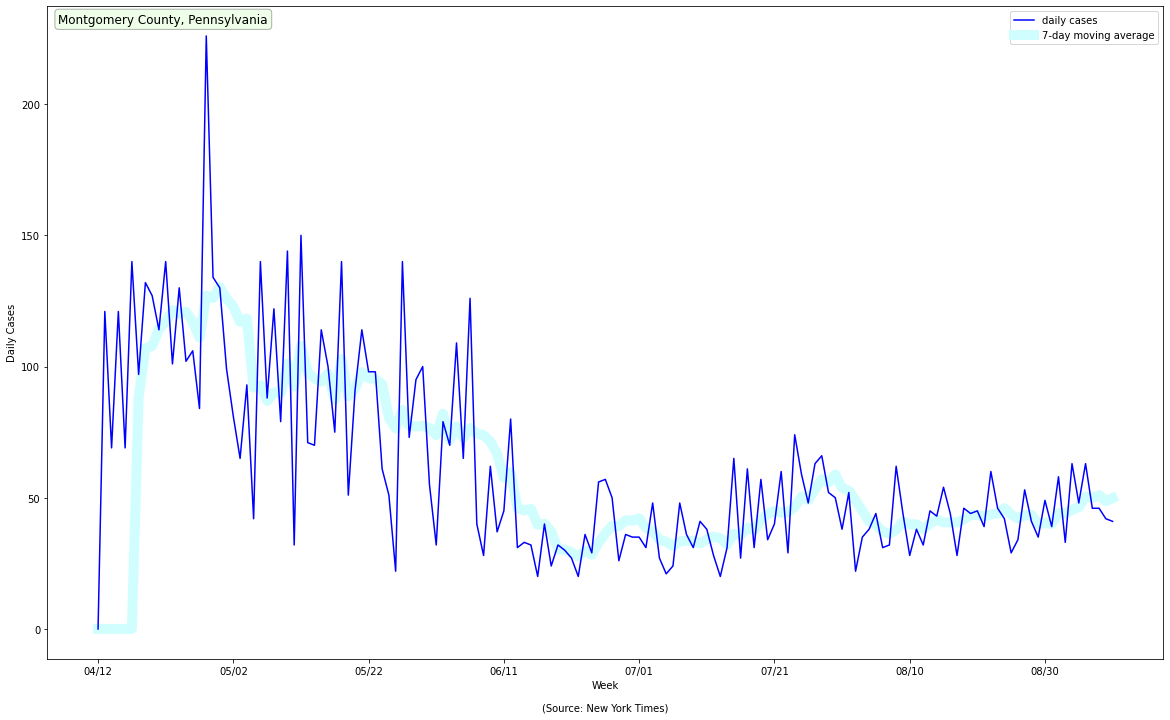

In [62]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-pa-montgomery-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab408c9d0>)

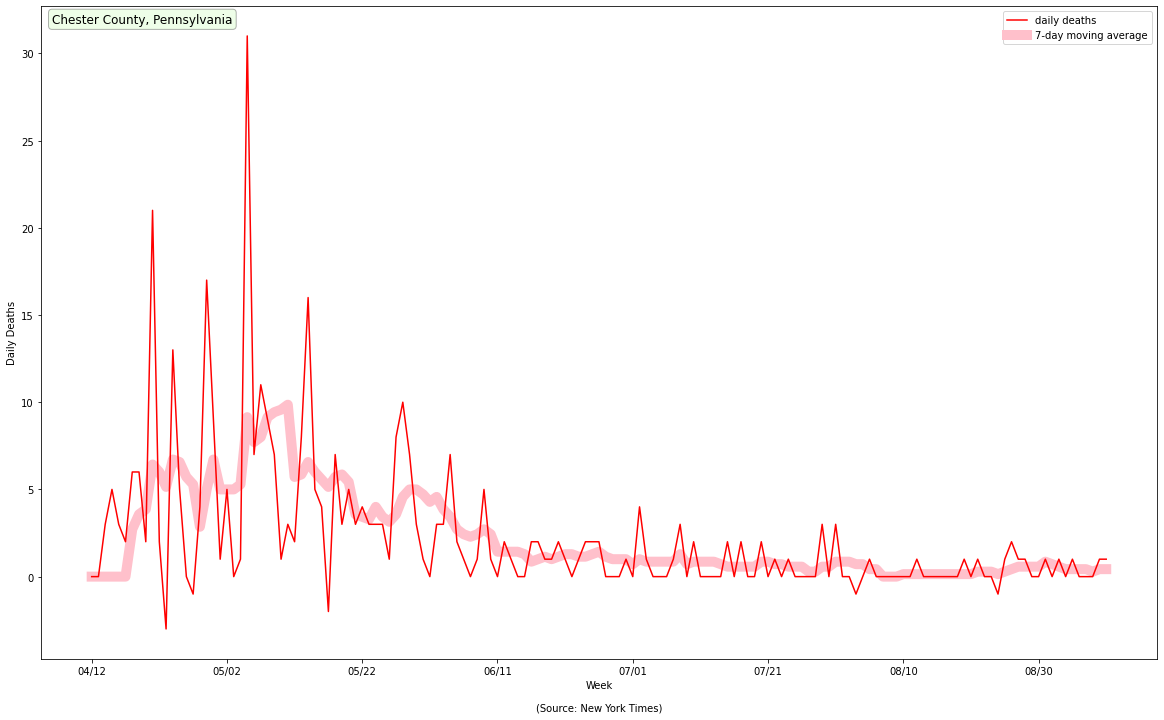

In [63]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-pa-chester-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab4045f40>)

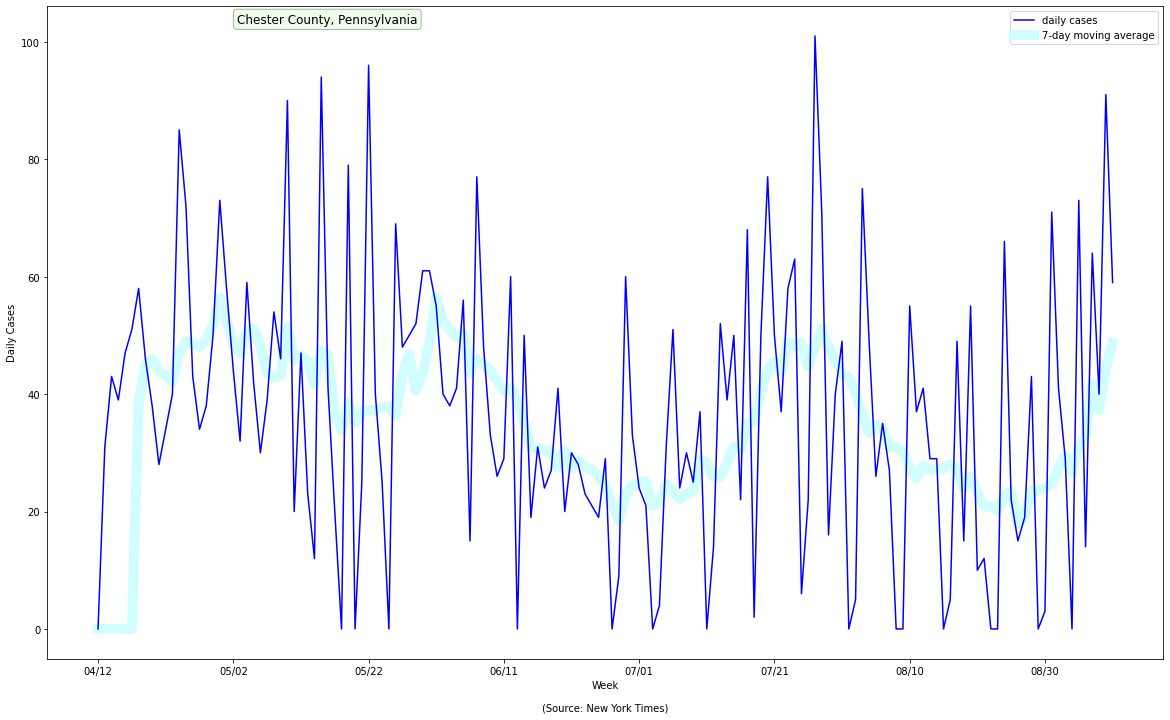

In [64]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=(0.17, 0.99), image_file='nyt-pa-chester-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2aa97918e0>)

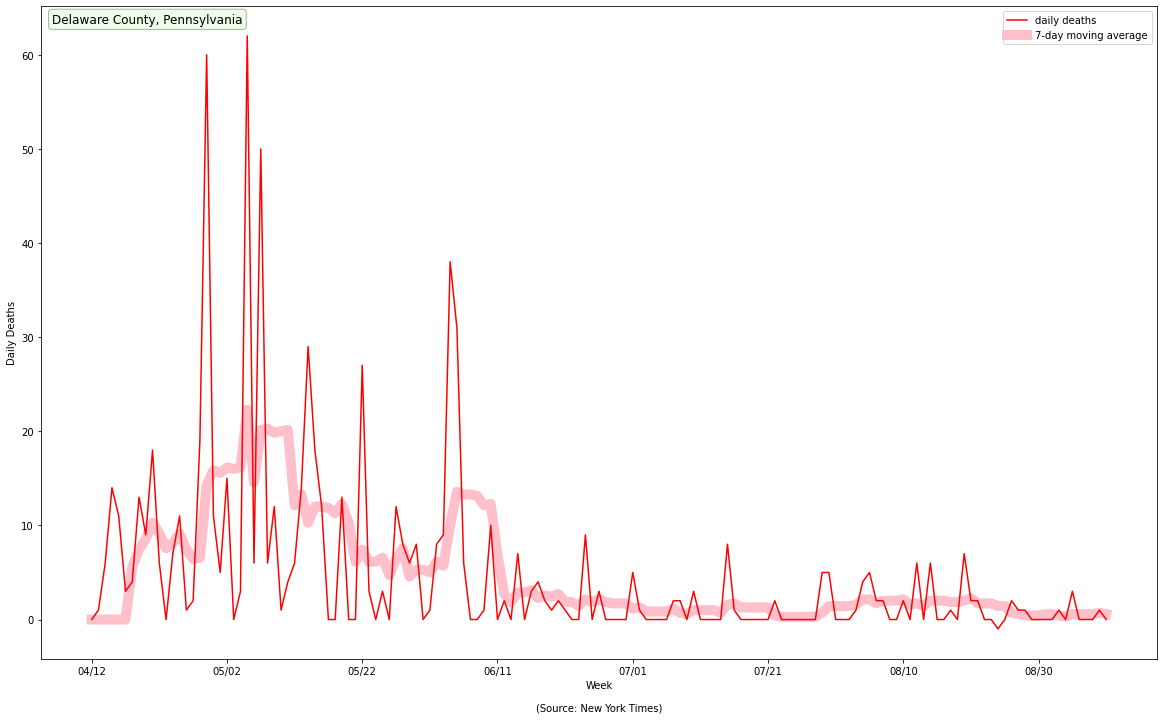

In [65]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-pa-delaware-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2aa9711760>)

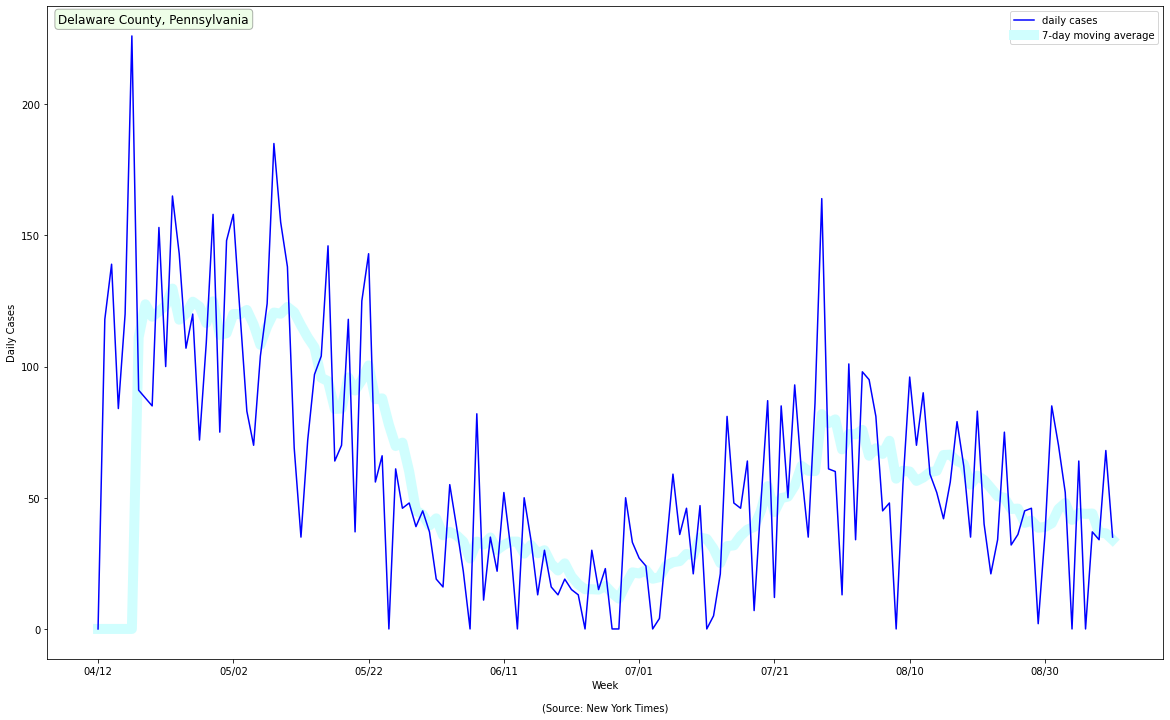

In [66]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-pa-delaware-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab41a2bb0>)

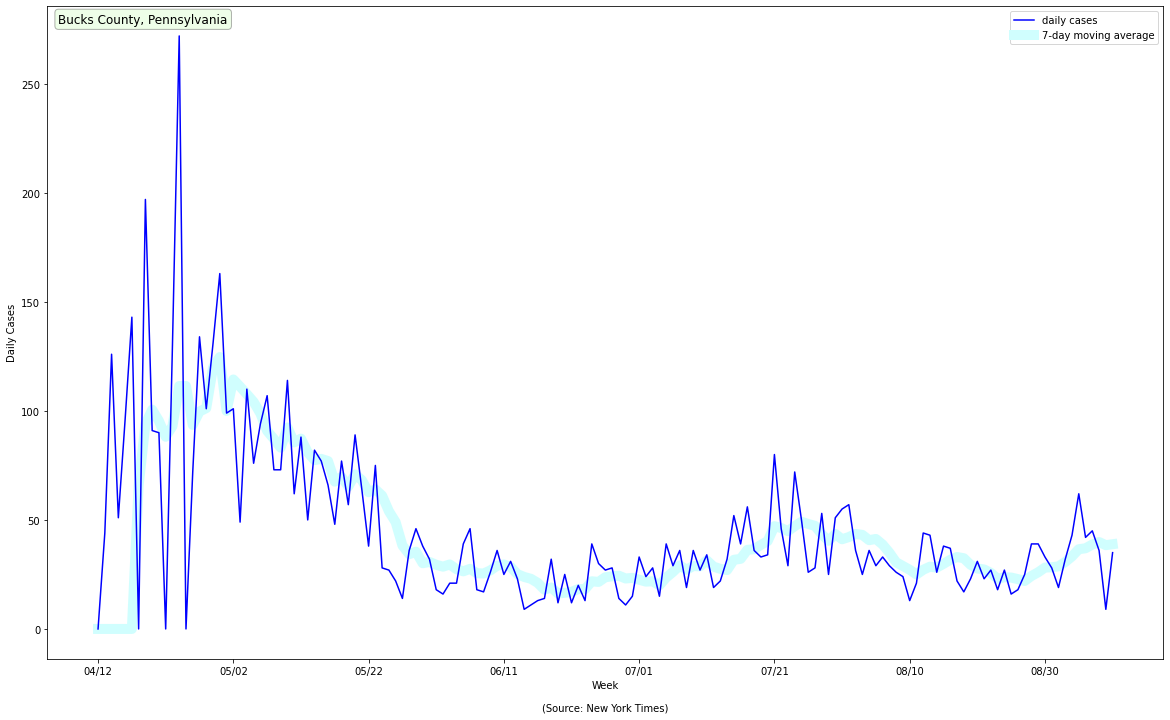

In [67]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-pa-bucks-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab4289ca0>)

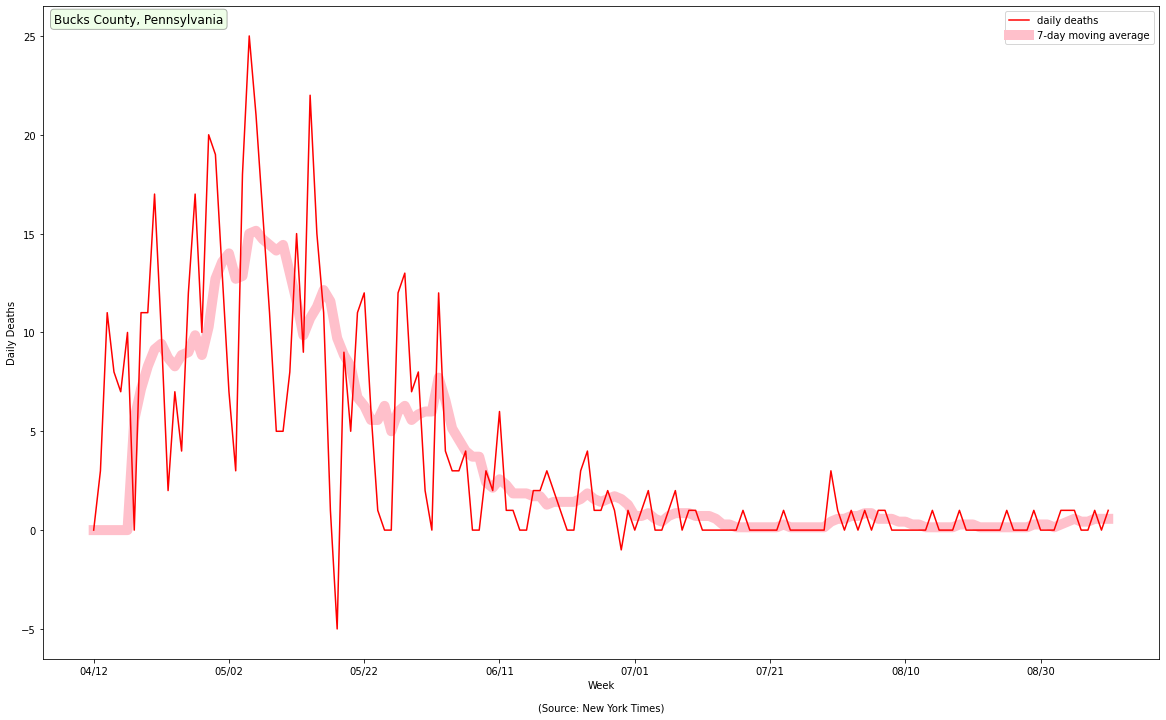

In [68]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-pa-bucks-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab430d880>)

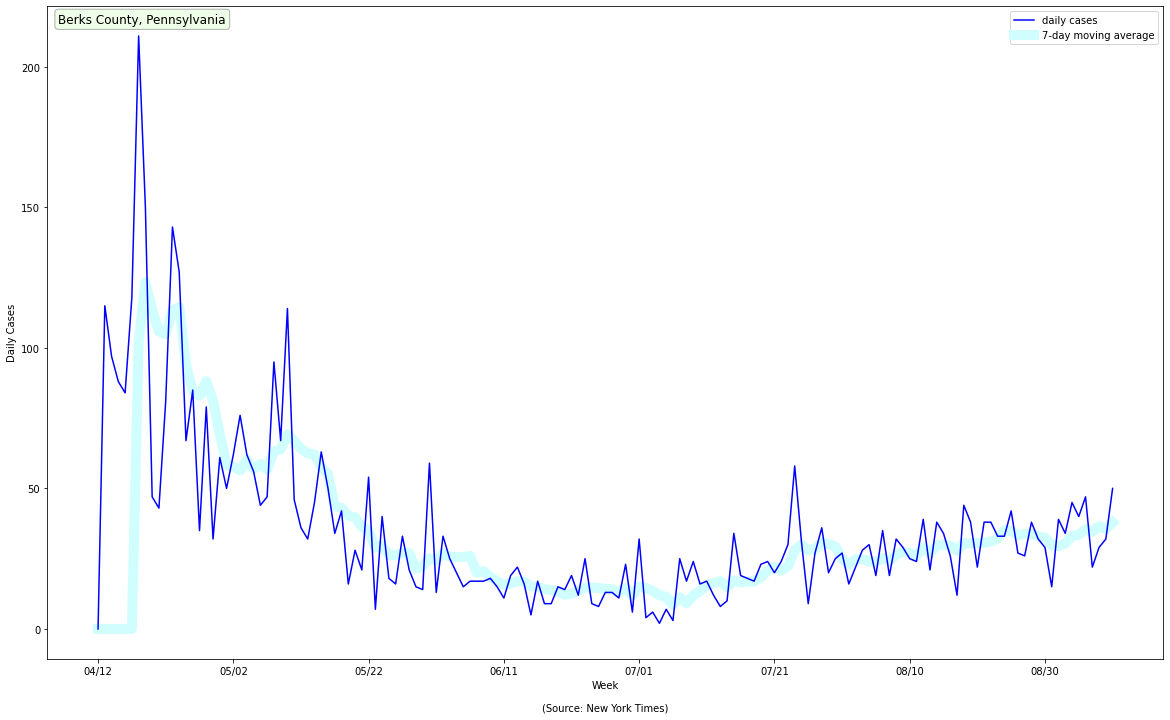

In [69]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-pa-berks-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab437b850>)

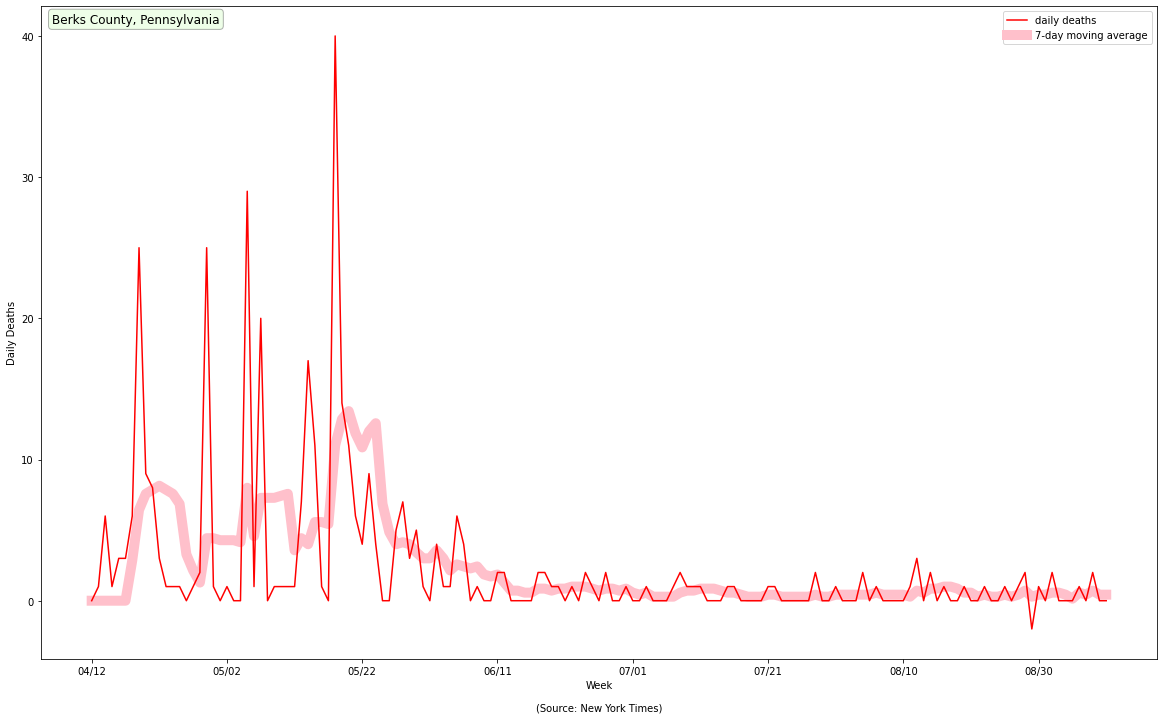

In [70]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-pa-berks-county-daily-deaths.png')

### Florida 

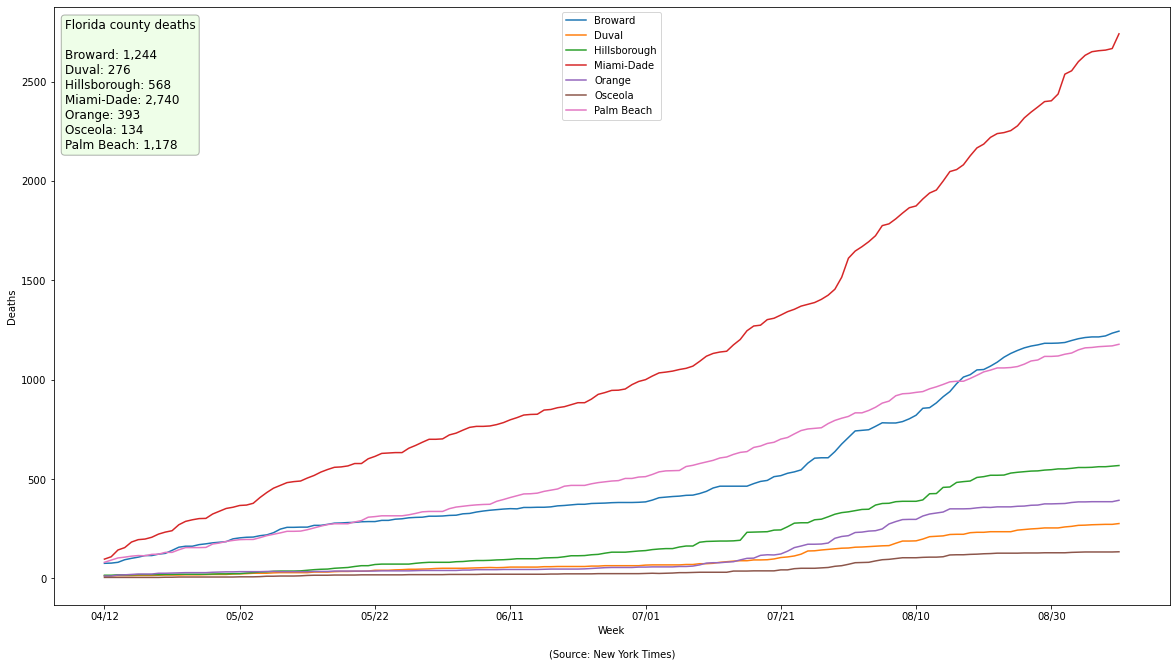

In [71]:
# Osceola and Orange are near Orlando.
# Hillsborough contains Tampa.
# Broward and Palm Beach are near Miami.
# Duval contains Jacksonville.
fl_counties = ('Osceola', 'Orange', 'Miami-Dade', 'Palm Beach',
               'Broward', 'Hillsborough', 'Duval')
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-deaths.png', source=SOURCE, metric=MetricType.DEATHS)

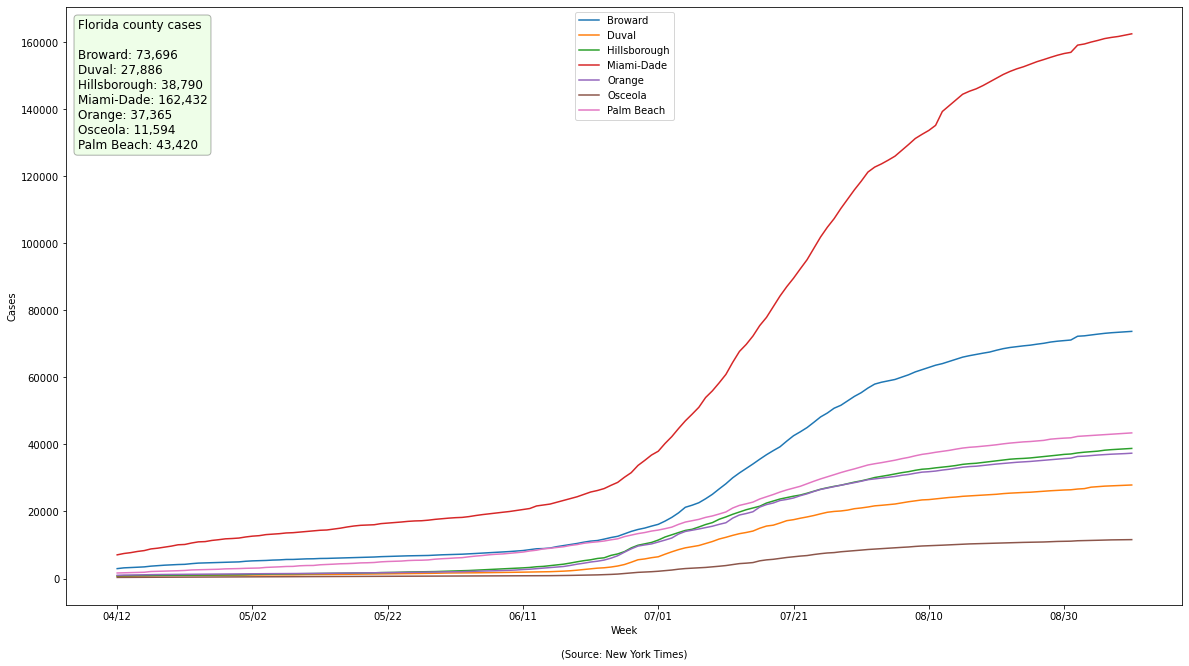

In [72]:
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-cases.png', source=SOURCE, metric=MetricType.CASES)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab4239a60>)

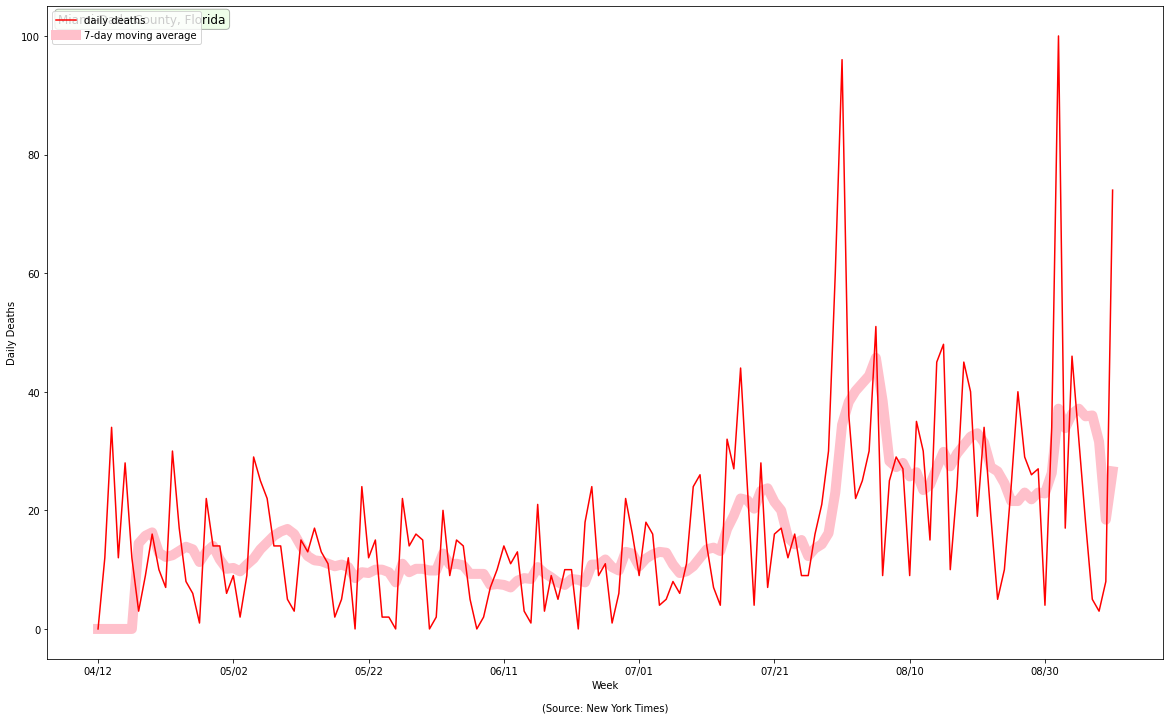

In [73]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-fl-miami-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ab43928b0>)

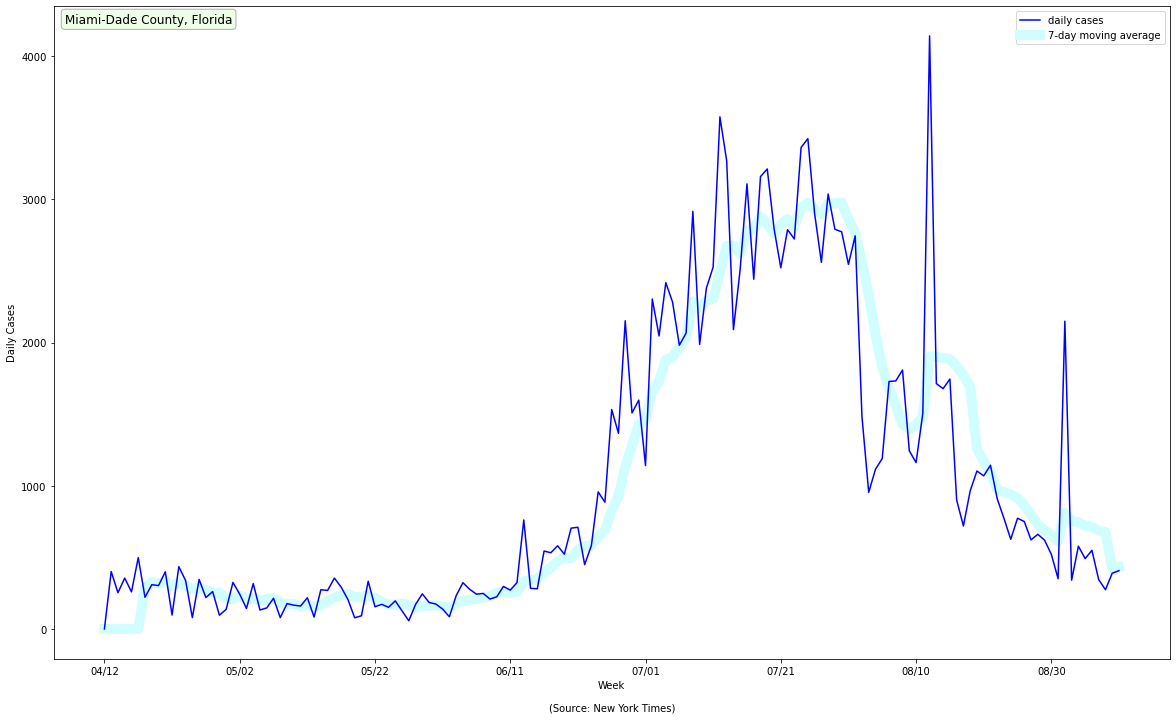

In [74]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-fl-miami-county-daily-cases.png')

### New York City

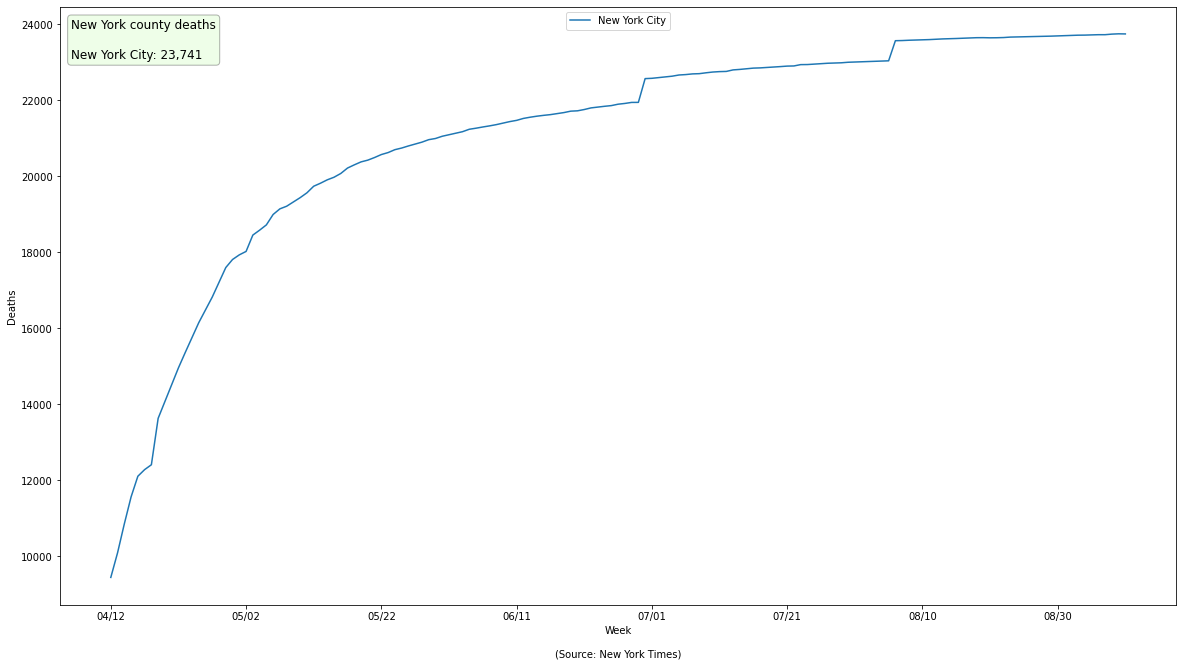

In [75]:
# The NY Times data coalesces the five New York City counties
# into "New York City".
plot_counties(df_counties, 'New York', ['New York City'], source=SOURCE, 
              image_file='nyt-nyc-county-deaths.png', metric=MetricType.DEATHS)